# **NBA predictions**

<p style="display: flex; align-items: center;">
    <img src="https://1000marcas.net/wp-content/uploads/2019/12/NBA-Logo.png" alt="NBA Logo" style="width: 500px; height: auto; margin-left: 0px;">
</p>

## Introduction

The NBA is one of the most popular sports leagues in the world, attracting millions of fans each year with its fast-paced games, high-flying dunks, and nail-biting finishes. While the excitement of each game is enough to keep fans on the edge of their seats, there is something even more thrilling about predicting which teams will make it to the NBA Finals and which players will receive individual awards.

Throughout this narrative, we will delve into the world of NBA predictions, analyzing the performance of individual players and examining the dynamics of team rosters. By understanding the playing styles and strategies of different players and teams, we can gain a better understanding of their strengths and weaknesses, as well as how they are likely to perform in different game scenarios.

Whether you're a seasoned fan or a newcomer to the world of basketball, our analysis will provide you with informative and engaging content that helps you stay up-to-date with the latest developments in the league. So, get ready to dive in and explore the exciting world of NBA predictions!

First of all, let's import the required libraries:

In [1]:
# Base Python libraries
import os
import yaml
from PIL import Image
# from io import BytesIO
import requests

# Data Science libraries
import numpy as np
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
# Bokeh
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, LinearInterpolator
from bokeh.io import output_notebook
# Seaborn
import seaborn as sns
# Folium
import folium
# Plotly
import plotly.express as px
import plotly.graph_objects as go

Now let's load the `YAML` configuration file:

In [2]:
with open("../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

Then, let's load the required data for the analysis:

In [3]:
# Therefore we can see all the columns from the DataFrame
pd.set_option('display.max_columns', 200)

In [4]:
# Team stats per game, per season
team_game = pd.read_csv("../data/Team Stats Per Game.csv")
# Team abbreviation
team_abbrev = pd.read_csv("../data/Team Abbrev.csv")
# Team stats summary per season
team_summary = pd.read_csv("../data/Team Summaries.csv")
# Stats of the opponent against each team per game, per season
opponent_game = pd.read_csv("../data/Opponent Stats Per Game.csv")
# Player stats per game, per season
player_per_game = pd.read_csv("../data/Player Per Game.csv")
# Advanced Statistics
player_advanced = pd.read_csv("../data/Advanced.csv")
# USA cities
usa_cities = pd.read_csv("../data/usa_cities.csv")

## 1. The NBA Map: Visualizing the Geography of the League

To make accurate NBA predictions, we first need to understand the league and the teams that make it up. The NBA consists of 30 teams located across North America, divided into two conferences: the Eastern Conference and the Western Conference. Each conference is further divided into three divisions.

The teams are spread across different cities and metropolitan areas, with some cities having more than one team. For example, Los Angeles has two NBA teams, the Lakers and the Clippers, while New York has another two teams, the Knicks and the Nets.

To help visualize the locations of the teams, we can create a map that displays the different cities and regions where the teams are located. This can be a useful tool for gaining a better understanding of the geographical distribution of the league, and can help inform our predictions throughout the season.

In [5]:
# Show dataset which will be used in this section
team_abbrev.head()

season   lg               team  playoffs abbreviation
0    2023  NBA      Atlanta Hawks     False          ATL
1    2023  NBA     Boston Celtics     False          BOS
2    2023  NBA      Brooklyn Nets     False          BRK
3    2023  NBA  Charlotte Hornets     False          CHO
4    2023  NBA      Chicago Bulls     False          CHI

In [6]:
# Get only current season
team_abbrev = team_abbrev.loc[team_abbrev["season"]==2023]
# Get automatically as much cities as we can from the team name
team_abbrev["city"] = team_abbrev["team"].str.split(" ").str[0]

# Set cities which could not be set automatically
team_abbrev.loc[2, "city"] = "New York"
team_abbrev.loc[9, "city"] = "San Francisco"
team_abbrev.loc[11, "city"] = "Indianapolis"
team_abbrev.loc[12, "city"] = "Los Angeles"
team_abbrev.loc[13, "city"] = "Los Angeles"
team_abbrev.loc[17, "city"] = "Minneapolis"
team_abbrev.loc[18, "city"] = "New Orleans"
team_abbrev.loc[19, "city"] = "New York"
team_abbrev.loc[20, "city"] = "Oklahoma City"
team_abbrev.loc[26, "city"] = "San Antonio"
team_abbrev.loc[28, "city"] = "Salt Lake City"
team_abbrev.loc[29, "city"] = "Washington, D.C."

In [7]:
# Inner JOIN of previous DataFrame with DataFrame of US cities
teams_loc = team_abbrev.merge(usa_cities, on="city", how="left").loc[:, ["team", "city", "abbreviation", "lat", "lng"]]

# Change latitude and longitude for teams in the same city than other (easier to visualize in the map)
teams_loc.loc[teams_loc["team"]=="Brooklyn Nets", ["lat", "lng"]] += 0.3
teams_loc.loc[teams_loc["team"]=="Los Angeles Clippers", ["lat", "lng"]] += 0.5

# Set latitude and longitude for Toronto Raptors (they're from Canada)
teams_loc.loc[teams_loc["team"]=="Toronto Raptors", ["lat", "lng"]] = [43.653225, -79.383186]

# Show first lines of output DataFrame
teams_loc.head()

team       city abbreviation        lat        lng
0      Atlanta Hawks    Atlanta          ATL  33.830014 -84.399949
1     Boston Celtics     Boston          BOS  42.329960 -71.070014
2      Brooklyn Nets   New York          BRK  41.049979 -73.680017
3  Charlotte Hornets  Charlotte          CHO  35.204995 -80.830038
4      Chicago Bulls    Chicago          CHI  41.829991 -87.750055

In [8]:
# Download NBA teams logo and save them in a specific directory
dir_name = "../images/NBA_logos"
os.makedirs(dir_name, exist_ok=True)
for team, url in zip(teams_loc["team"].values.tolist(), list(config["teams"].keys())):
    url = config["teams"][team]["url"]
    response = requests.get(url)
    with open(f"{dir_name}/{team}.jpeg", "wb") as f:
        f.write(response.content)

In [9]:
# Get local path of NBA teams logos
logos_path = []
for dir in os.walk(dir_name):
    for file in dir[2]:
        logos_path.append(f"{dir_name}/{file}")

In [10]:
# Get team colors from config file
team_colors = []
for team in config["teams"].keys():
    team_colors.append(config["teams"][team]["color"])

In [11]:
teams_loc

team              city abbreviation        lat   
0            Atlanta Hawks           Atlanta          ATL  33.830014  \
1           Boston Celtics            Boston          BOS  42.329960   
2            Brooklyn Nets          New York          BRK  41.049979   
3        Charlotte Hornets         Charlotte          CHO  35.204995   
4            Chicago Bulls           Chicago          CHI  41.829991   
5      Cleveland Cavaliers         Cleveland          CLE  41.469987   
6         Dallas Mavericks            Dallas          DAL  32.820024   
7           Denver Nuggets            Denver          DEN  39.739188   
8          Detroit Pistons           Detroit          DET  42.329960   
9    Golden State Warriors     San Francisco          GSW  37.740008   
10         Houston Rockets           Houston          HOU  29.819974   
11          Indiana Pacers      Indianapolis          IND  39.749988   
12    Los Angeles Clippers       Los Angeles          LAC  34.489978   
13      Los Angeles Lakers       Los Angeles          LAL  33.989978   
14       Memphis Grizzlies           Memphis          MEM  35.119987   
15              Miami Heat             Miami          MIA  25.787611   
16         Milwaukee Bucks         Milwaukee          MIL  43.052655   
17  Minnesota Timberwolves       Minneapolis          MIN  44.979979   
18    New Orleans Pelicans       New Orleans          NOP  29.995002   
19         New York Knicks          New York          NYK  40.749979   
20   Oklahoma City Thunder     Oklahoma City          OKC  35.470043   
21           Orlando Magic           Orlando          ORL  28.509977   
22      Philadelphia 76ers      Philadelphia          PHI  39.999973   
23            Phoenix Suns           Phoenix          PHO  33.539980   
24  Portland Trail Blazers          Portland          POR  45.520024   
25        Sacramento Kings        Sacramento          SAC  38.575021   
26       San Antonio Spurs       San Antonio          SAS  29.487333   
27         Toronto Raptors           Toronto          TOR  43.653225   
28               Utah Jazz    Salt Lake City          UTA  40.775016   
29      Washington Wizards  Washington, D.C.          WAS  38.899549   

           lng  
0   -84.399949  
1   -71.070014  
2   -73.680017  
3   -80.830038  
4   -87.750055  
5   -81.694998  
6   -96.840017  
7  -104.984016  
8   -83.080056  
9  -122.459978  
10  -95.339979  
11  -86.170048  
12 -117.679980  
13 -118.179980  
14  -89.999995  
15  -80.224106  
16  -87.919967  
17  -93.251786  
18  -90.039967  
19  -73.980017  
20  -97.518684  
21  -81.380030  
22  -75.169996  
23 -112.069992  
24 -122.679990  
25 -121.470038  
26  -98.507305  
27  -79.383186  
28 -111.930052  
29  -77.009419

In [12]:
# Add color and logo path of each team to the DataFrame
teams_loc["color"] = team_colors.copy()
teams_loc["logo_path"] = logos_path.copy()


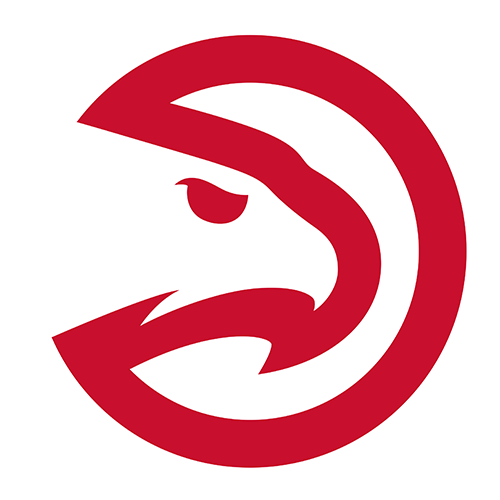
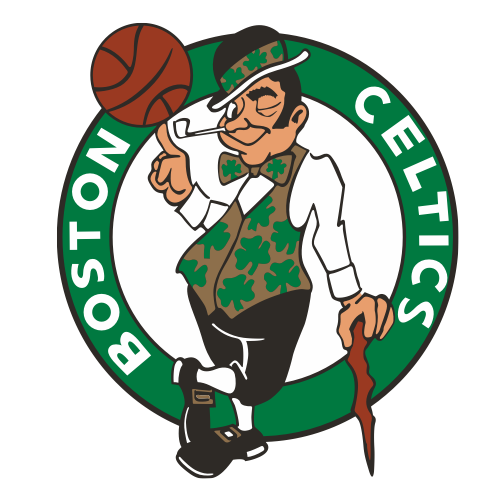
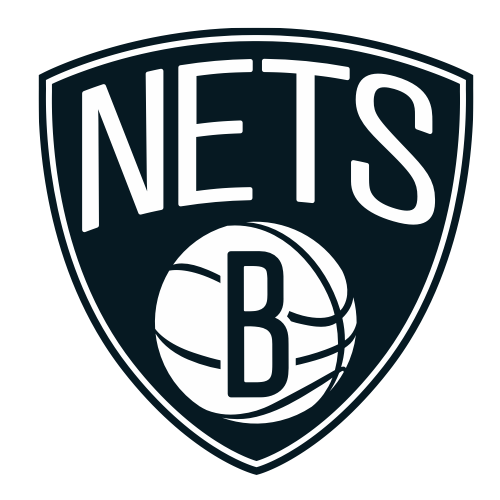
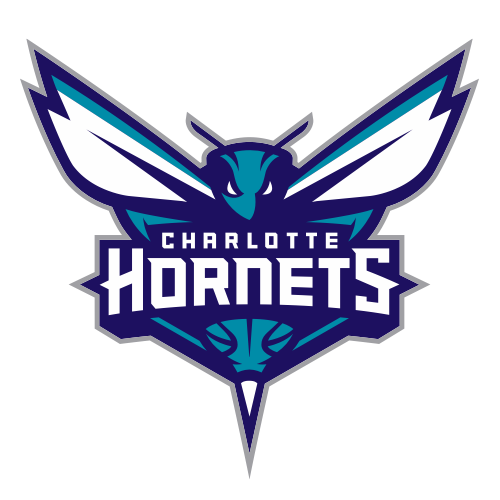
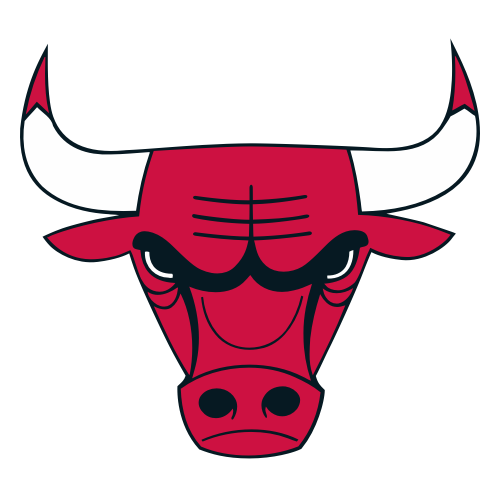
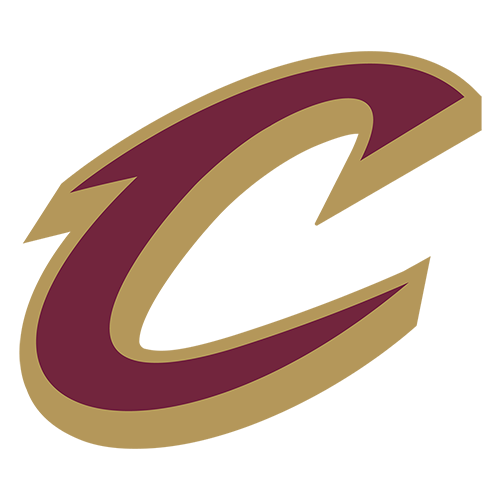
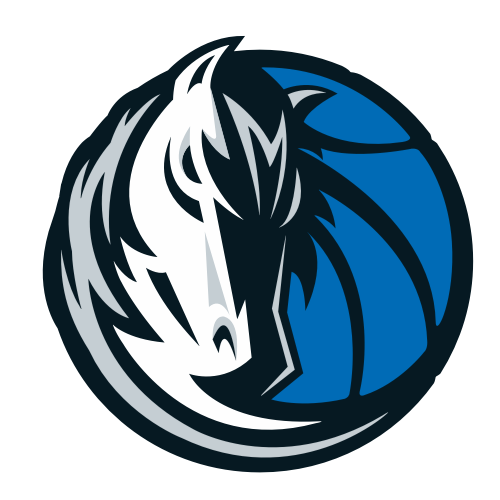
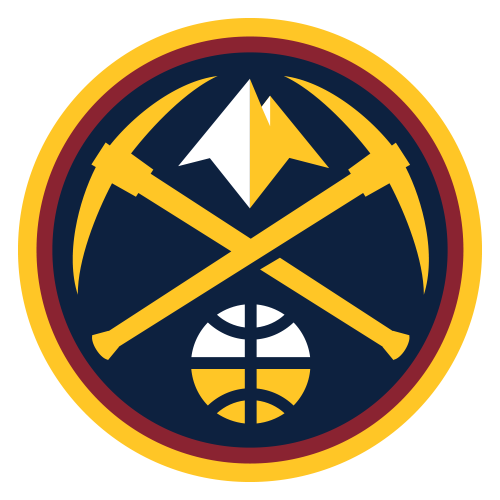
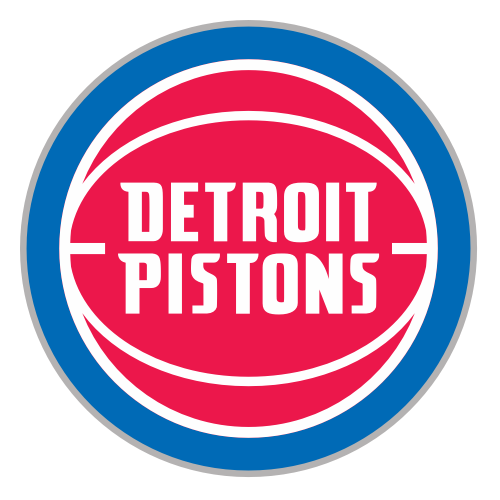
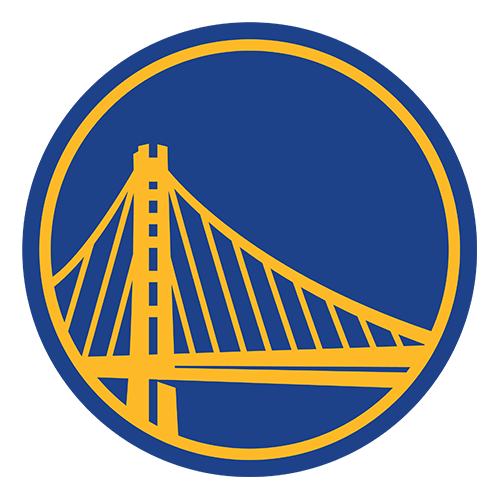
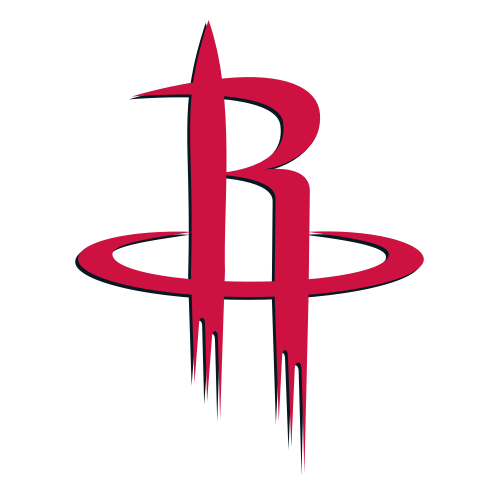
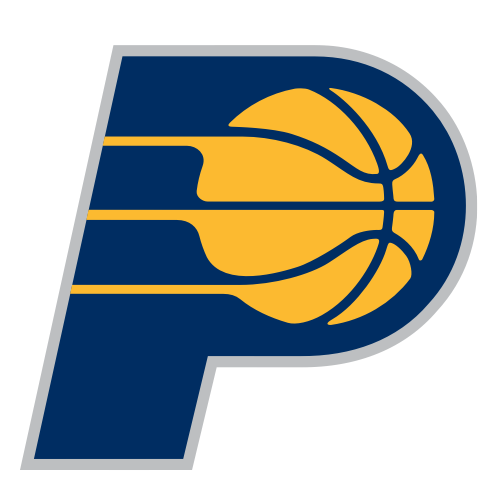
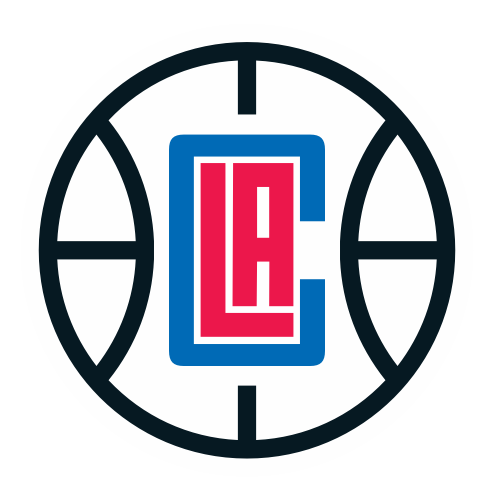
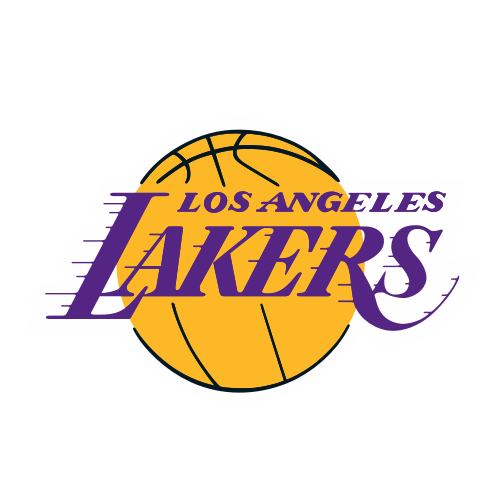
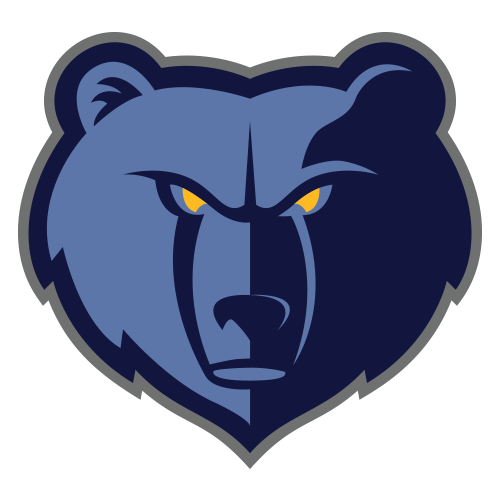
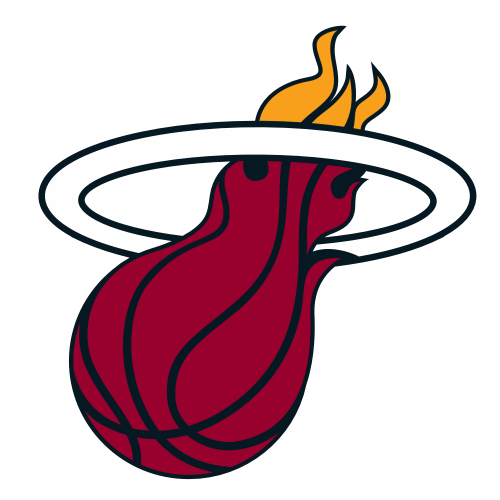
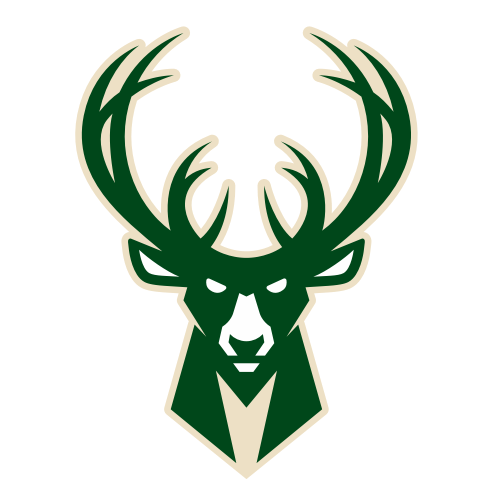
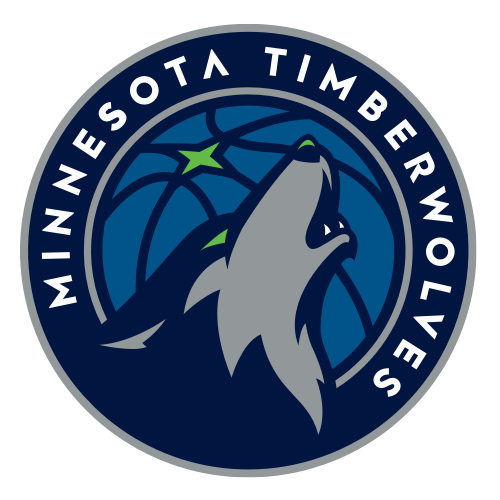
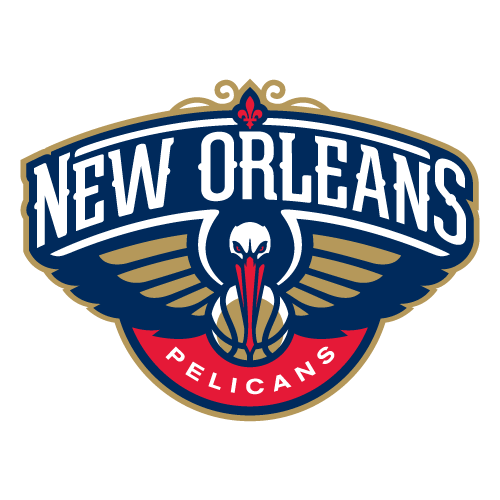
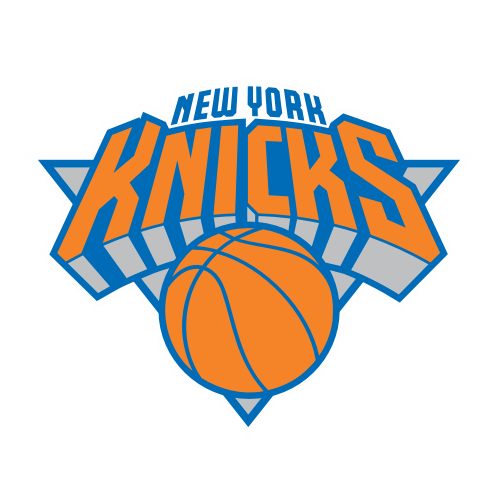
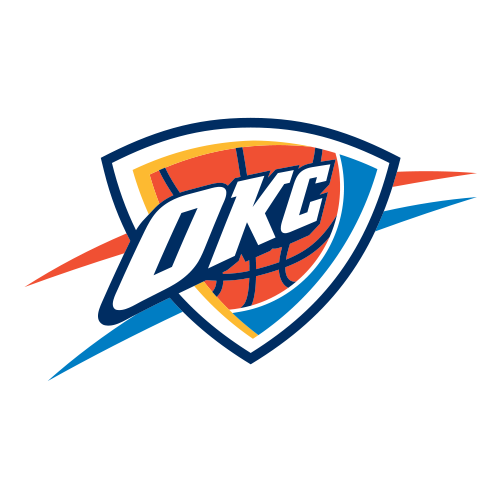
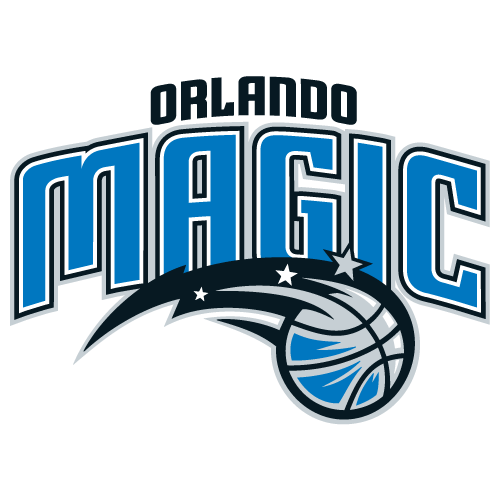
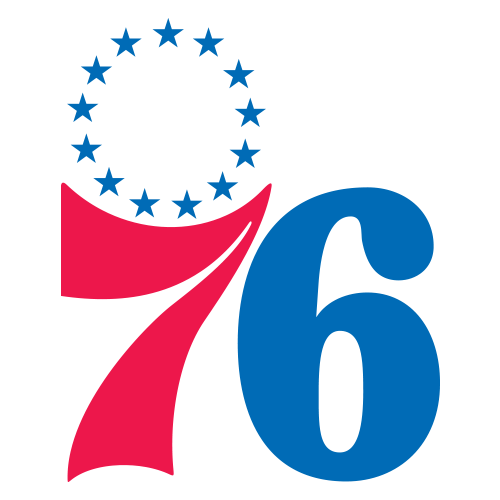
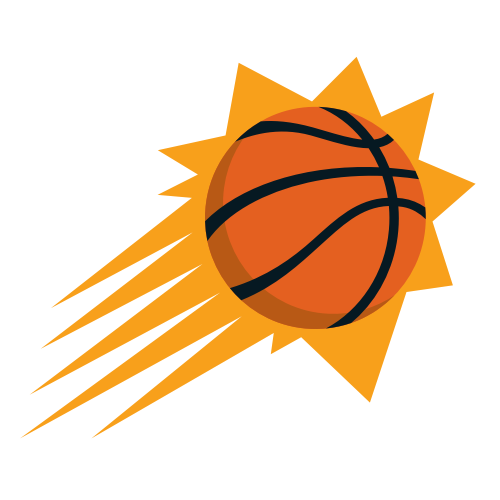
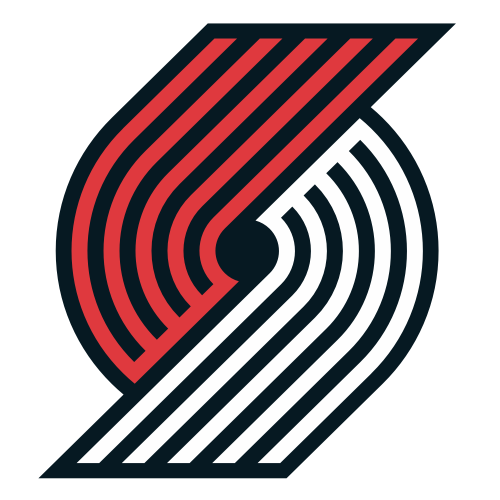
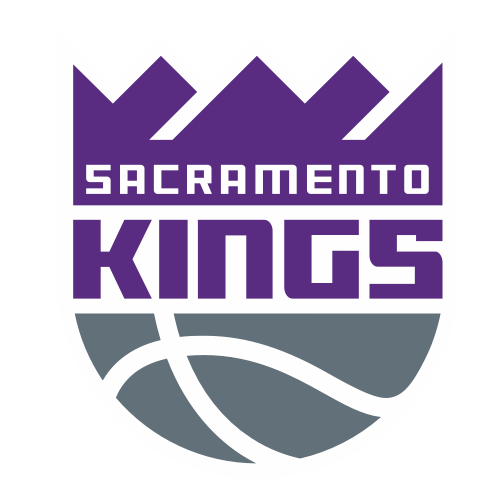
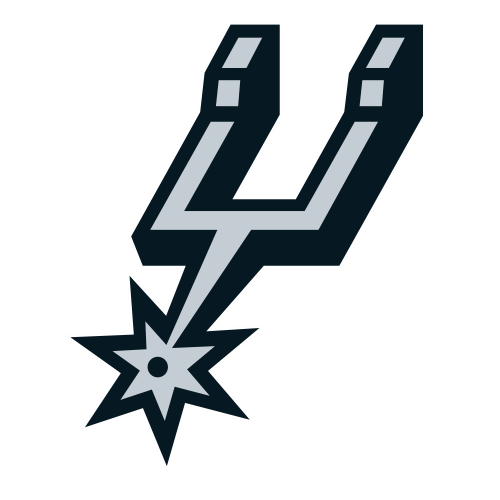
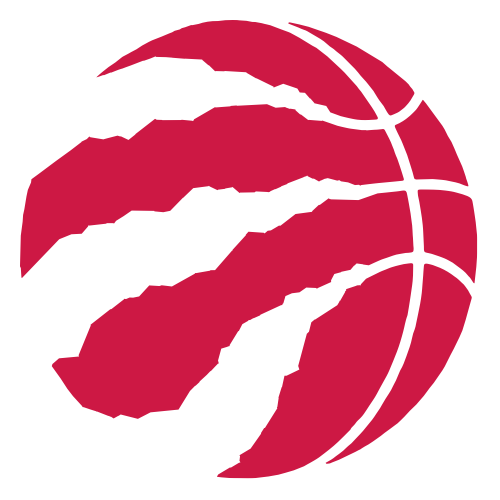
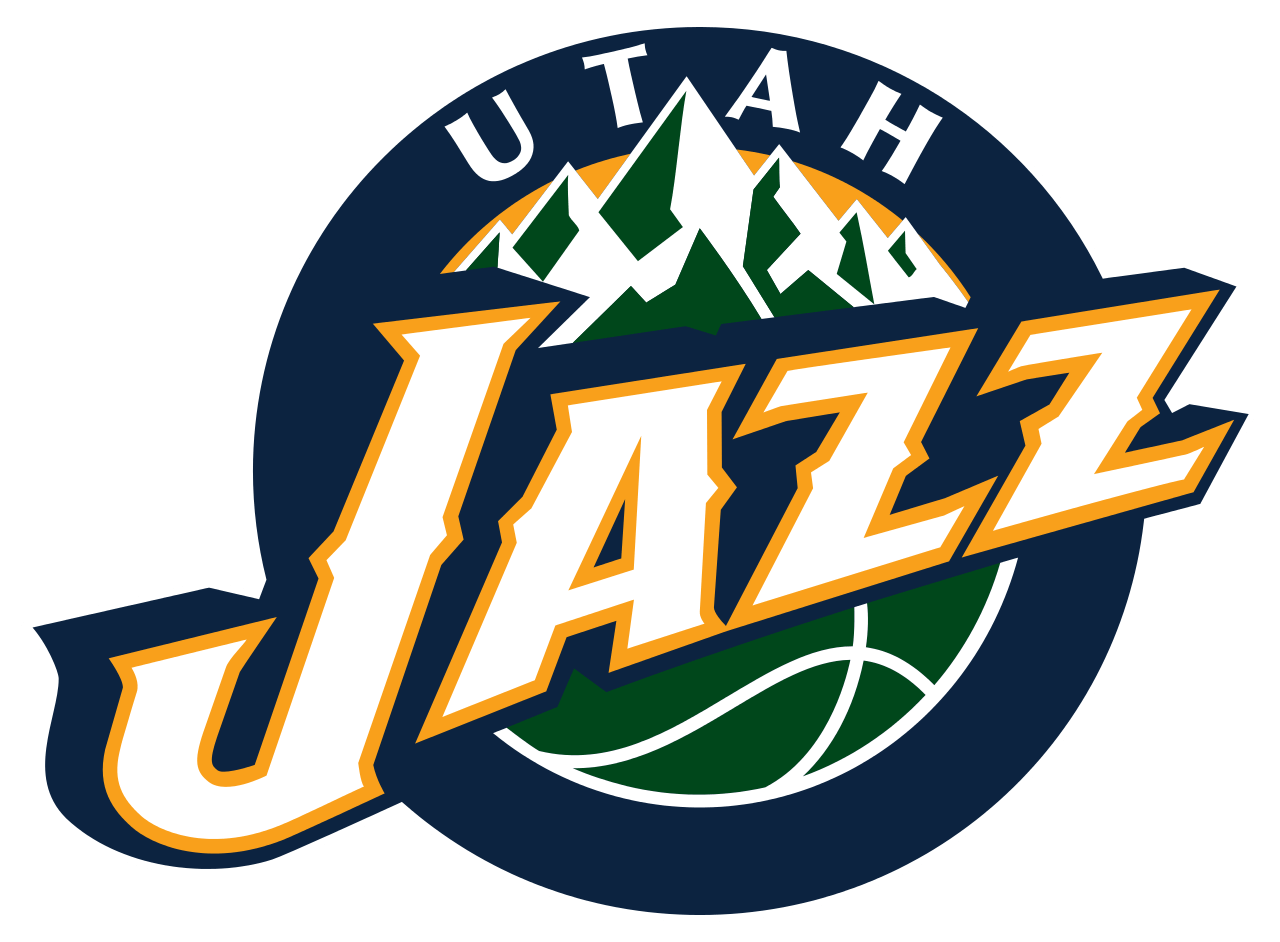
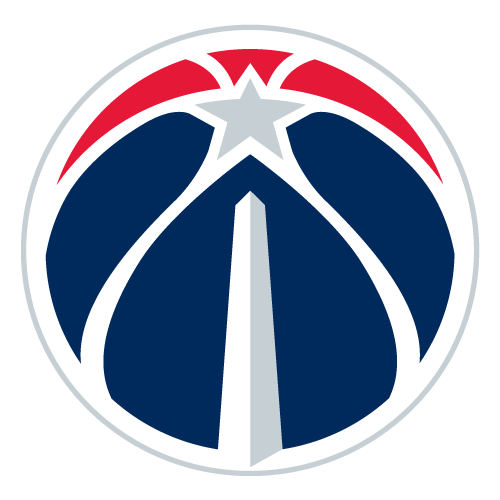

In [13]:
# Create a map centered on the US with a higher zoom level
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add logo for each NBA team to the map
for index, values in teams_loc.iterrows():
    # Load team logo and get aspect ratio
    img_path = values["logo_path"]
    img = Image.open(img_path)
    width, height = img.size
    aspect_ratio = width / height
    # Tooltip
    tooltip = f"{values['team']} ({values['city']})"
    # Insert team logo in its corresponding location in the map
    folium.Marker(
        location=[values["lat"], values["lng"]], 
        icon=folium.features.CustomIcon(
            values["logo_path"], 
            icon_size=(aspect_ratio*50, 50),
            ),
        tooltip=tooltip
        ).add_to(m)

# Display the map
m

From the map, it is evident that there is a higher concentration of NBA teams located along the East Coast. However, despite what one might initially assume, the league is actually divided into two conferences, each comprising 15 teams:

- **Eastern Conference**: This conference is made up of teams located along the East Coast. This is where Michael Jordan famously led the Chicago Bulls against the Bad Boys in the 90s. The Boston Celtics are the most successful team in this conference, with a total of 17 titles. Interestingly, there is also a team from Canada, the Toronto Raptors, in this conference. The Eastern Conference is further divided into three divisions: Atlantic, Central, and Southeast, each comprising five teams. Teams in the same division play against each other more frequently than teams in other divisions.


- **Western Conference**: The teams in this conference are located closer to the West coast, with the Memphis Grizzlies and New Orleans Pelicans being the closest teams to the East Coast. The most iconic team in this conference is the Los Angeles Lakers, with the same number of titles as the Boston Celtics, and legendary players such as Magic Johnson, Kareem Abdul-Jabbar, and Kobe Bryant. The Western Conference is also divided into three divisions: Northwest, Pacific, and Southwest, each comprising five teams. As with the Eastern Conference, teams in the same division play against each other more frequently than teams in other divisions.

The map also highlights the fact that teams located closer to each other tend to play against each other more frequently than teams located further apart. This is due to the fact that teams in closer proximity can travel to each other's arenas more easily, allowing for more games to be scheduled between them. This can impact the balance of the league as a whole, as teams that play against each other more frequently may develop stronger rivalries and have more opportunities to build momentum and confidence over the course of the season.

Overall, understanding the structure of the NBA, including its conferences and divisions, as well as the impact of proximity on scheduling, is crucial for making accurate predictions about the upcoming season.

# 2. The Current NBA Standings: Who's on Top and Who's Struggling

<p style="display: flex; align-items: center;">
    <img src="https://cdn.nba.com/manage/2021/09/larry-obrien-trophy-2022.jpg" alt="NBA title" style="width: 1100px; height: auto; margin-left: 0px;">
</p>


Now that we have a good understanding of the geography and structure of the NBA, let's take a closer look at the current classification of teams within each conference. This will give us a sense of how each team is performing so far this season, and help us identify potential contenders for the NBA championship. In this section, we'll examine the current standings for both the Eastern and Western conferences, highlighting the top teams in each conference and any noteworthy trends or surprises. Let's get started!

In [14]:
# See first lines of the DataFrame
team_summary.head()

season   lg               team abbreviation  playoffs   age     w     l   
0    2023  NBA      Atlanta Hawks          ATL     False  24.9  29.0  30.0  \
1    2023  NBA     Boston Celtics          BOS     False  27.3  42.0  17.0   
2    2023  NBA      Brooklyn Nets          BRK     False  28.4  34.0  24.0   
3    2023  NBA      Chicago Bulls          CHI     False  27.5  26.0  33.0   
4    2023  NBA  Charlotte Hornets          CHO     False  25.6  17.0  43.0   

     pw    pl   mov   sos   srs  o_rtg  d_rtg  n_rtg   pace   f_tr  x3p_ar   
0  29.0  30.0 -0.36 -0.22 -0.58  114.6  115.0   -0.4  100.6  0.235   0.329  \
1  40.0  19.0  6.14 -0.35  5.78  117.9  111.7    6.2   98.6  0.251   0.479   
2  32.0  26.0  1.72  0.05  1.77  115.8  114.1    1.7   98.3  0.251   0.381   
3  29.0  30.0 -0.29  0.33  0.04  112.5  112.8   -0.3   99.7  0.256   0.331   
4  19.0  41.0 -6.42  0.38 -6.04  110.0  116.3   -6.3  101.2  0.258   0.360   

   ts_percent  e_fg_percent  tov_percent  orb_percent  ft_fga   
0       0.571         0.535         11.1         23.5   0.192  \
1       0.602         0.565         12.1         21.7   0.207   
2       0.609         0.577         13.1         19.3   0.199   
3       0.584         0.546         12.5         20.1   0.208   
4       0.548         0.514         11.8         24.9   0.192   

   opp_e_fg_percent  opp_tov_percent  opp_drb_percent  opp_ft_fga   
0             0.543             12.6             75.2       0.211  \
1             0.531             11.3             79.0       0.178   
2             0.526             12.1             74.0       0.224   
3             0.543             13.1             78.2       0.203   
4             0.552             13.0             74.9       0.215   

              arena    attend  attend_g  
0  State Farm Arena  472275.0   17492.0  
1         TD Garden  574680.0   18538.0  
2   Barclays Center  510458.0   17602.0  
3     United Center  587881.0   20272.0  
4   Spectrum Center  463990.0   17185.0

In [15]:
# Get team's conference from config file
conference = []
for team in config["teams"].keys():
    conference.append(config["teams"][team]["conference"])

In [16]:
# Get data from current season and remove the League Average information
classification = team_summary.loc[
    (team_summary["season"]==2023) 
    & (team_summary["team"]!="League Average")
    ].loc[:, ["team", "w"]].sort_values(by="team")

# Add conference each teams belong to (info in the config file)
classification["conference"] = conference.copy()
# Add color for each team
classification["color"] = team_colors.copy()
# Show first lines
classification.head()

team     w conference    color
0      Atlanta Hawks  29.0    Eastern  #e03a3e
1     Boston Celtics  42.0    Eastern  #007a33
2      Brooklyn Nets  34.0    Eastern  #000000
4  Charlotte Hornets  17.0    Eastern  #1d1160
3      Chicago Bulls  26.0    Eastern  #ce1141

In [17]:
# Get data for East and West coast
east = classification.loc[classification["conference"]=="Eastern"].sort_values(by="w", ascending=True)
west = classification.loc[classification["conference"]=="Western"].sort_values(by="w", ascending=True)

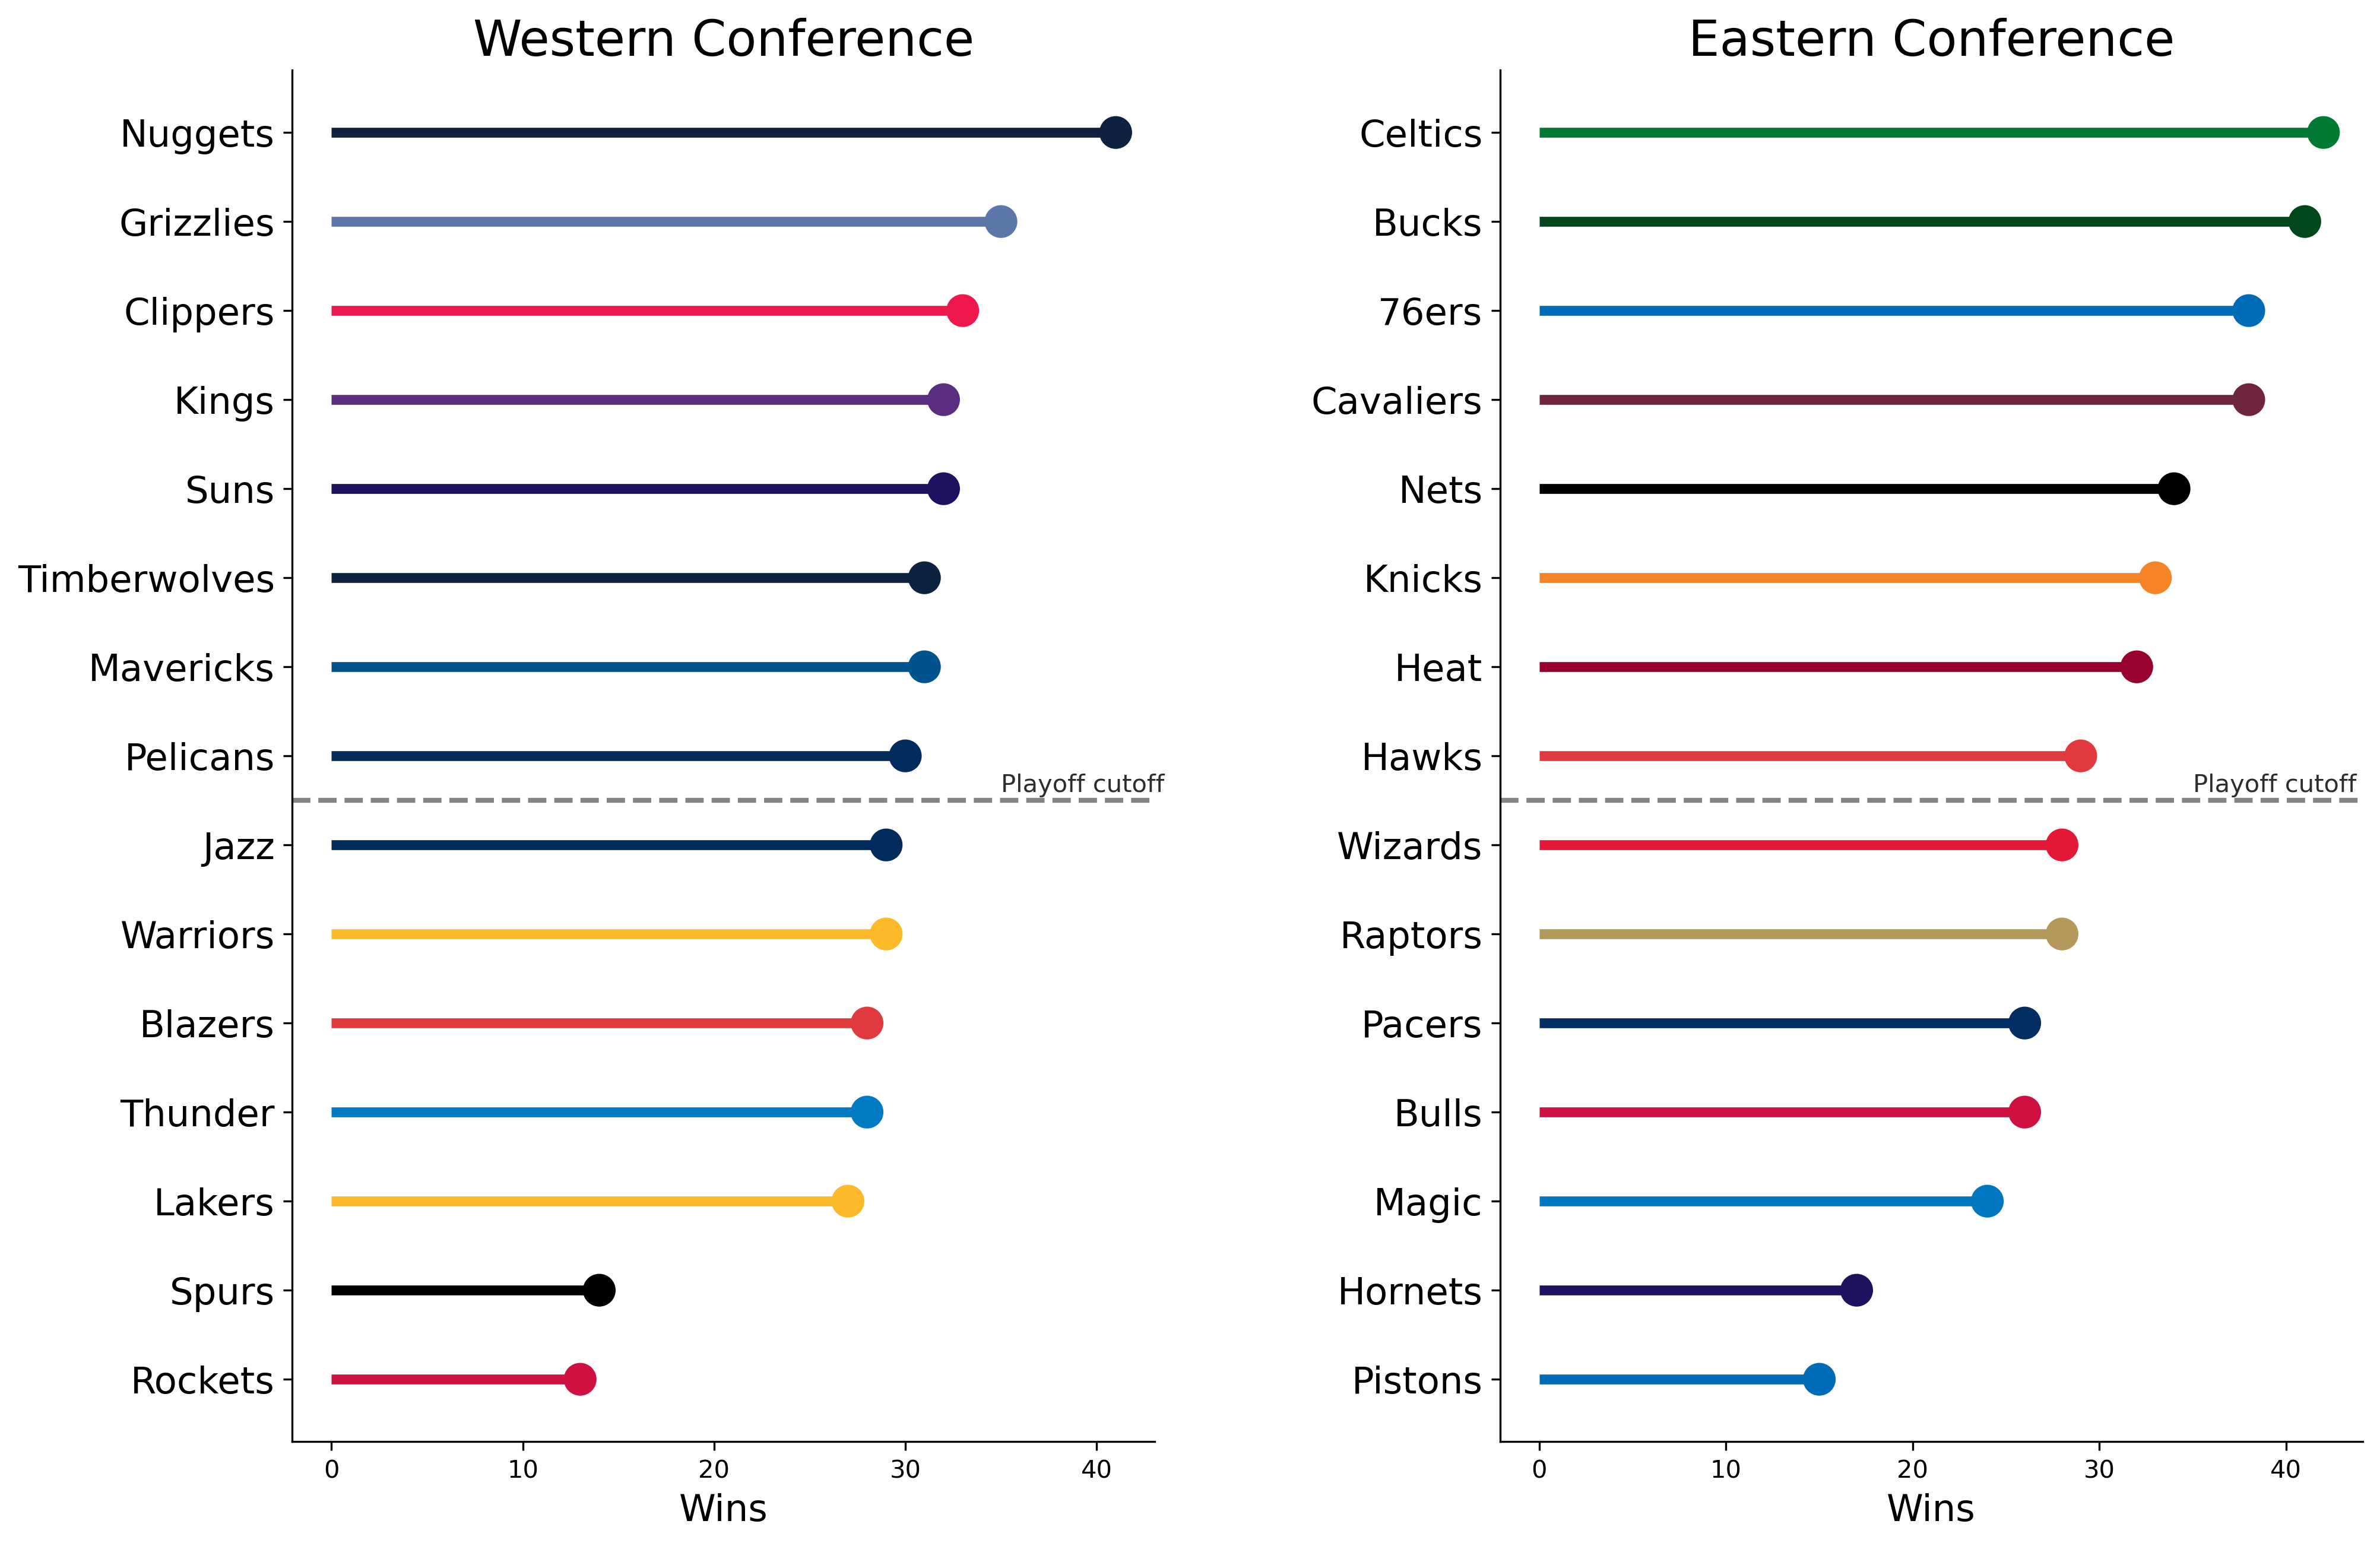

In [18]:
# Create the subplots
sns.reset_defaults()
# sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), dpi=300)

# Variables for threshold (Playoff cutoff)
playoff_threshold = 7
playoff_threshold_max = 1
playoff_threshold_color = "#848484"
# Variables for the text shown in the plot
text = "Playoff cutoff"
text_color = "#2D2D2D"
text_x = 35
# Xlabel name variable
xlabel = "Wins"

# Y-axis label names
labels_west = west["team"].str.split(" ").str[-1].values.tolist()
labels_east = east["team"].str.split(" ").str[-1].values.tolist()


# FIRST LOLLIPOP PLOT
ax1.hlines(y=west["team"], xmin=0, xmax=west["w"], color=west["color"].values.tolist(), linewidth=4)
ax1.scatter(west["w"], west["team"], color=west["color"].values.tolist(), s=150)
ax1.axhline(y=playoff_threshold-0.5, xmax=playoff_threshold_max, color=playoff_threshold_color, 
            linestyle="--", linewidth=2)
ax1.text(y=playoff_threshold-0.4, x=text_x, s=text, color=text_color, fontsize=10)
ax1.set_yticks(np.arange(0, len(labels_west)))
ax1.set_yticklabels(labels=labels_west, fontsize=15)
ax1.set_xlabel(xlabel, fontsize=15)
ax1.set_title("Western Conference", fontsize=20)

# SECOND LOLLIPOP PLOT
ax2.hlines(y=east["team"], xmin=0, xmax=east["w"], color=east["color"].values.tolist(), linewidth=4)
ax2.scatter(east["w"], east["team"], color=east["color"].values.tolist(), s=150)
ax2.axhline(y=playoff_threshold-0.5, xmax=playoff_threshold_max, color=playoff_threshold_color, 
            linestyle="--", linewidth=2)
ax2.text(y=playoff_threshold-0.4, x=text_x, s=text, color=text_color, fontsize=10)
ax2.set_yticks(np.arange(0, len(labels_east)))
ax2.set_yticklabels(labels=labels_east, fontsize=15)
ax2.set_xlabel(xlabel, fontsize=15)
ax2.set_title("Eastern Conference", fontsize=20)

# Add some spacing between the subplots
plt.subplots_adjust(wspace=0.4)
# Remove box from both plots
sns.despine()

# Show the plot
plt.show()

The position a team finishes in the regular season standings is critical to its chances of advancing to the NBA Finals. This is because the playoffs follow a seeded bracket system, where the top team in each conference plays the eighth seed, the second plays the seventh, and so on. Therefore, teams with higher standings are matched up against theoretically weaker opponents in the first round of the playoffs, giving them an easier path to the championship.

Currently, the Denver Nuggets lead the Western Conference, while the Boston Celtics lead the Eastern Conference with the Milwaukee Bucks close behind. While only the top eight teams from each conference make the playoffs, there are still many teams in the hunt for a spot in the postseason. Only the San Antonio Spurs and Houston Rockets in the Western Conference, and the Charlotte Hornets and Detroit Pistons in the Eastern Conference, appear to have little chance of making it to the playoffs.

In the next sections, we'll dive deeper into the performance of the top teams in each conference and assess their chances of making it to the NBA Finals.

## 3. Winning in Style: Which Teams Are Proving Their Dominance on the Court?

<p style="display: flex; align-items: center;">
    <img src="https://as01.epimg.net/baloncesto/imagenes/2020/10/30/nba/1604075419_203378_1604075619_noticia_normal.jpg" alt="Bulls Jordan" style="width: 1100px; height: auto; margin-left: 0px;">
</p>

When it comes to making predictions about which team will come out on top in the NBA season, it's not just about who wins, but also about how convincingly they win. A team that consistently dominates their opponents with large margins is likely to have a stronger chance of success than one that only narrowly ekes out victories.

In this section, we will examine which teams tend to win by the largest margins, using data on point differentials throughout the season. We'll explore the teams that have the highest average point differential and take a closer look at how they achieve these convincing wins. This information can help us better understand which teams are the most dominant and which are likely to go far in the playoffs.

In [19]:
# Get data from current season and remove the League Average information
df1 = team_game.loc[
    (team_game["season"]==2023) 
    & (team_game["team"]!="League Average")
    ].loc[:, ["team", "pts_per_game"]]
# Get data from current season and remove the League Average information
df2 = opponent_game.loc[
    (team_game["season"]==2023) 
    & (team_game["team"]!="League Average")
    ].loc[:, ["team", "opp_pts_per_game"]]

# Inner JOIN between both DataFrames
df = df1.merge(df2, how="inner", on="team")
# Get new column as the difference between team pts per game and opponent's pts per game
df["pts_diff"] = df["pts_per_game"] - df["opp_pts_per_game"]
# Sort values from lowest difference to highest
df.sort_values(by="pts_diff", ascending=False, inplace=True)

In [20]:
# Get colormap
my_cmap = plt.get_cmap("cividis")
# rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
# Define scale for colormap
rescale = lambda y: (2*y - (np.max(y) + np.min(y))) / (np.max(y) - np.min(y))

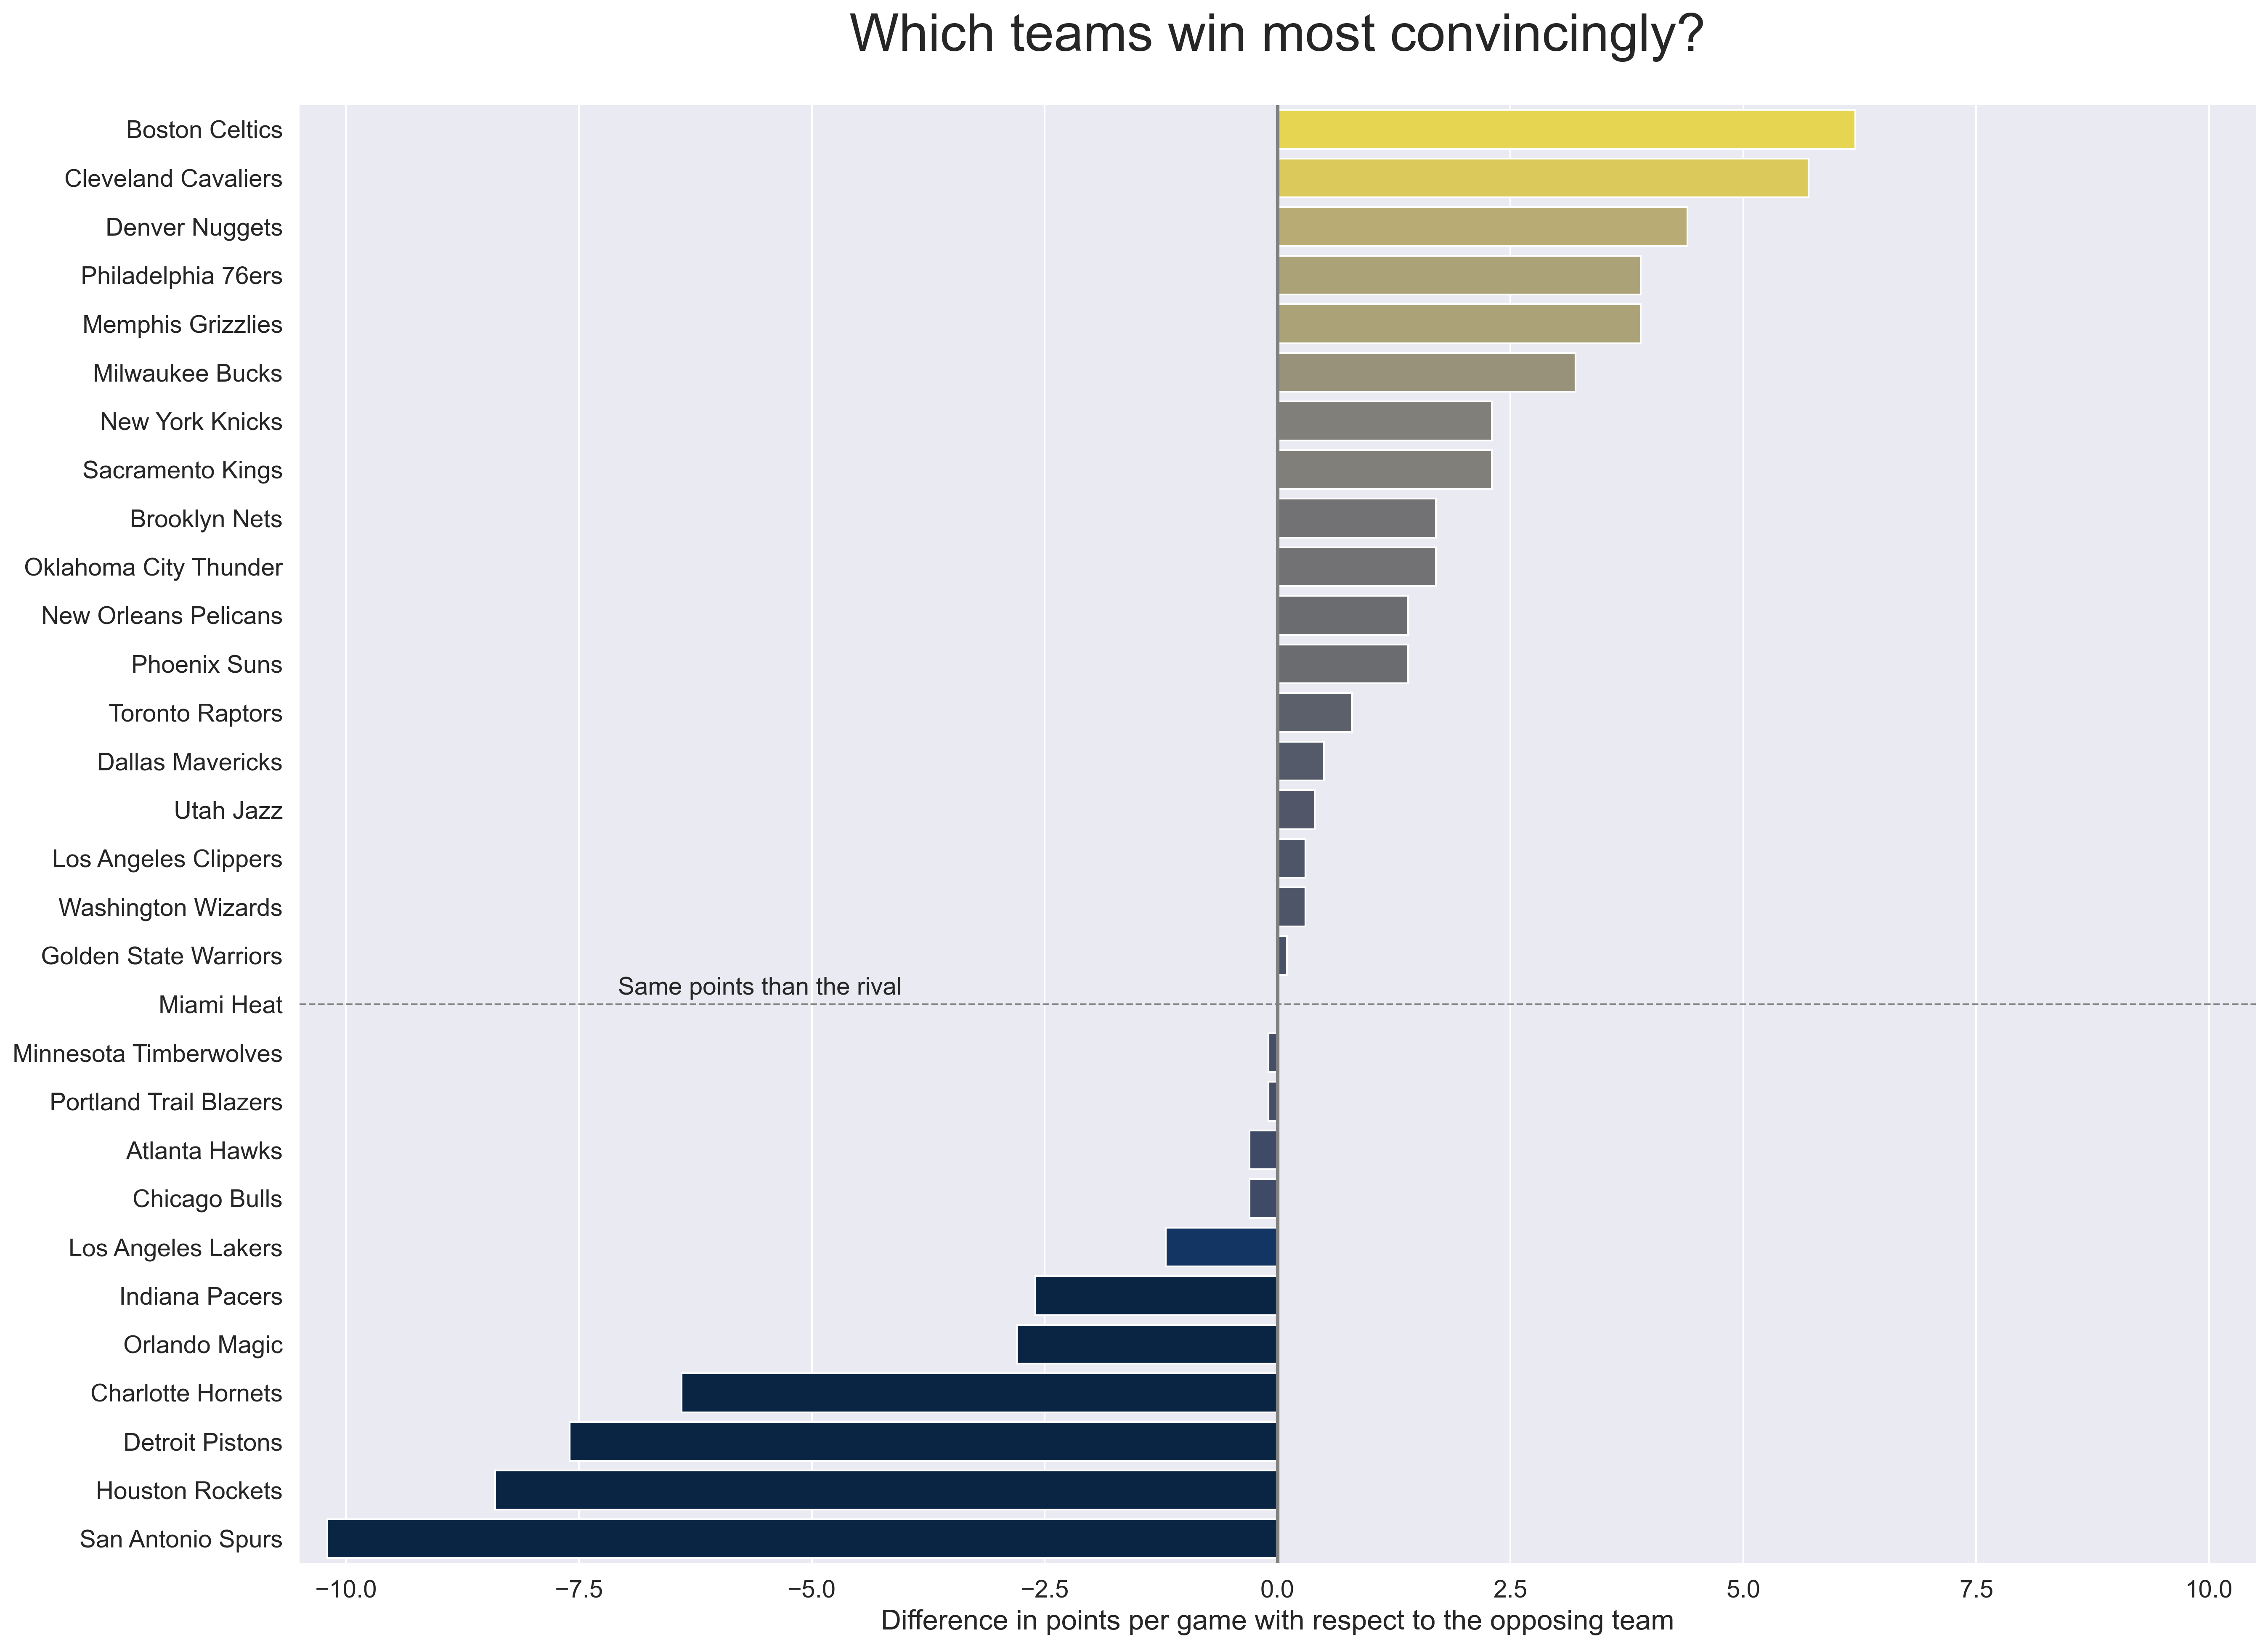

In [21]:
# Figure size and dpi
plt.figure(figsize=(20,15), dpi=300)
# Theme
sns.set()
sns.set_theme()
# Horizontal barplot
sns.barplot(data=df, x="pts_diff", y="team", palette=my_cmap(rescale(df["pts_diff"])))
# Vertical line for x=0
plt.axvline(x=0, color="gray", linewidth=2)
# Horizontal line for y=0 (i.e., same pts than opponent)
plt.axhline(y=18, color="gray", linewidth=1, linestyle="--")
plt.text(x=-7.08, y=17.8, s="Same points than the rival", fontsize=14)

plt.title("Which teams win most convincingly?", fontsize=30, x=0.5, y=1.03)
plt.xlabel("Difference in points per game with respect to the opposing team", fontsize=16)
plt.ylabel("")
plt.xlim(-10.5, 10.5)
plt.tick_params(labelsize=14)

# Remove left axis
sns.despine(left=True, bottom=True)
plt.show()

Upon analyzing the chart, we can observe that the Boston Celtics and Cleveland Cavaliers are the teams that win their games with the largest point differential, averaging over 5 points more than their opponents. They are followed closely by the Denver Nuggets, Philadelphia 76ers, Memphis Grizzlies, and Milwaukee Bucks, all of which have an average point differential of over 2.5 points against their opponents. It appears that the Eastern Conference has more teams in contention for the NBA title this year, as four out of the six teams mentioned belong to that conference.

Additionally, the teams with the least chance of reaching the playoffs are also the teams that tend to lose by the largest margin against their opponents, namely the San Antonio Spurs and Houston Rockets in the Western Conference, as well as the Charlotte Hornets and Detroit Pistons in the Eastern Conference. The Orlando Magic and Indiana Pacers, also from the Eastern Conference, are the next two teams that lose by the largest point differential.

Therefore, we can conclude that predicting which teams will make it to the playoffs in the Eastern Conference may be easier due to the larger point differentials, but predicting the team that will make it to the finals may be more challenging due to the higher number of contenders.

## 4. Examining Teams' Shooting Styles: 2-Pointers vs. 3-Pointers

<p style="display: flex; align-items: center;">
    <img src="https://cdn.nba.com/manage/2021/12/GettyImages-1237234542-scaled-e1639533882574.jpg" alt="Curry" style="width: 1100px; height: auto; margin-left: 0px;">
</p>

In recent years, the NBA game has evolved as teams have started to rely more on the 3-point shot. This change has been largely attributed to the success of the Golden State Warriors, led by Stephen Curry, who revolutionized the game with their prolific 3-point shooting. In this section, we will examine how each team attacks by analyzing their field goal percentages, specifically focusing on the percentage of shots taken from beyond the arc versus inside the arc. By doing so, we can gain insight into each team's shooting style and their overall offensive strategy.

In [22]:
# Get DataFrame with relevant columns and NBA average
columns = ["team", "x3p_per_game", "x2p_per_game"]
df = team_game.loc[
    (team_game["season"]==2023) 
    & (team_game["team"]!="League Average")
    ].loc[:, columns].sort_values(by="team")
league_avg = team_game.loc[
    (team_game["season"]==2023) 
    & (team_game["team"]=="League Average")
    ].loc[:, columns]

# Get percentages instead of absolute values
df["x3p_per_game"] = df["x3p_per_game"] / (df["x3p_per_game"] + df["x2p_per_game"])
df["x2p_per_game"] = 1
league_avg["x3p_per_game"] = league_avg["x3p_per_game"] / (league_avg["x3p_per_game"] + league_avg["x2p_per_game"])
league_avg["x2p_per_game"] = 1

# Add conference
df["conference"] = conference.copy()

# Sort by 3-points attempts, descendant
df.sort_values(by="x3p_per_game", ascending=False, inplace=True)

# Split by conference
east = df.loc[df["conference"]=="Eastern"]
west = df.loc[df["conference"]=="Western"]

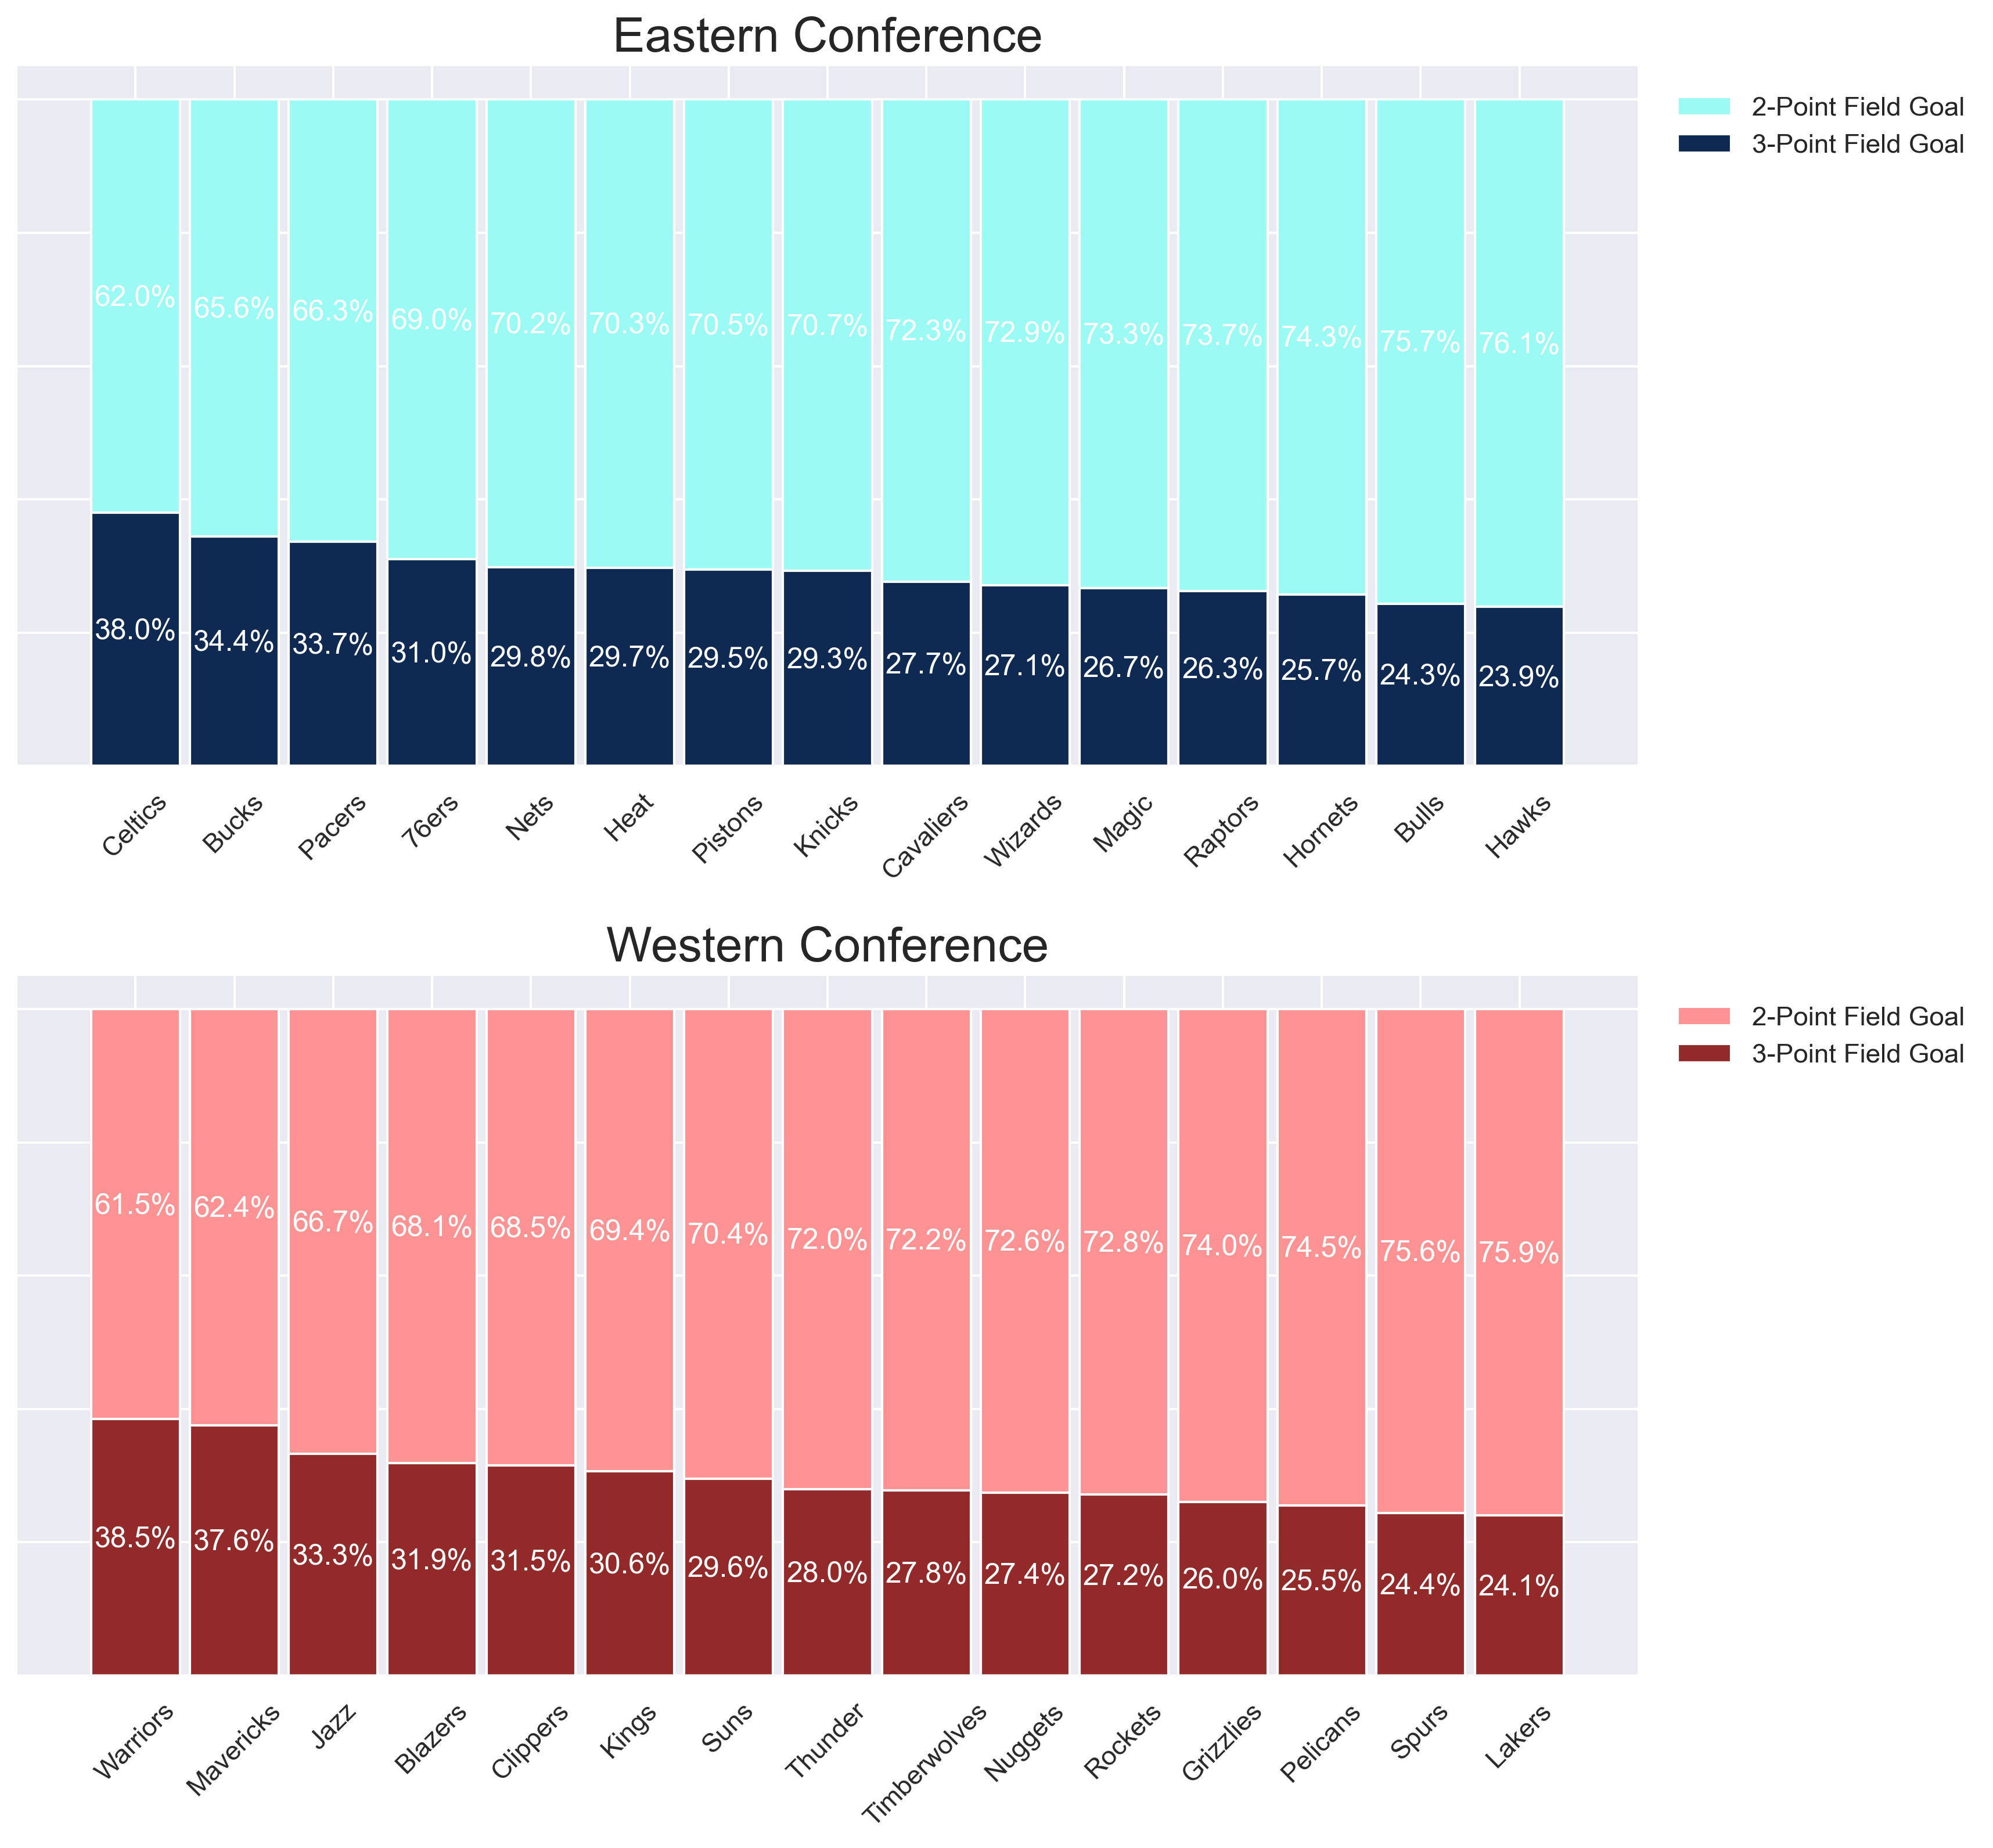

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), dpi=300)

# Text aligment in each bar
text_aligment = "center"
# Text color in each bar
text_color = "#FFFFFF"

# Legend labels
label_3pa = "3-Point Field Goal"
label_2pa = "2-Point Field Goal"

# X-labels names
labels_east = east["team"].str.split(" ").str[-1]
labels_west = west["team"].str.split(" ").str[-1]

# Remove box from both plots
sns.despine()

# Barplots for East conference
ax1.bar(x=east["team"], height=east["x2p_per_game"], width=0.9, color='#9BFAF3', label=label_2pa)
ax1.bar(x=east["team"], height=east["x3p_per_game"], width=0.9, color='#0E2952', label=label_3pa)
# Xticks labels
ax1.set_xticks(np.arange(0, len(labels_east)))
ax1.set_xticklabels(labels=labels_east, rotation=45)
# Title
ax1.set_title("Eastern Conference", fontsize=20)
# Legend
ax1.legend(frameon=False, bbox_to_anchor=(1.01, 0.99))
# Remove left spine
ax1.spines[['left']].set_visible(False)
# Remove the y-labels
plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax1.get_yticklines(), visible=False)

# Include text in corresponding bar
for index, row in east.iterrows():
    ax1.text(row.team, (row.x3p_per_game + (1-row.x3p_per_game)/2), f"{round(100*(1-row.x3p_per_game), 1)}%", ha=text_aligment, color=text_color)
    ax1.text(row.team, row.x3p_per_game/2, f"{round(100*row.x3p_per_game, 1)}%", ha=text_aligment, color=text_color)

# Barplots for East conference
ax2.bar(x=west["team"], height=west["x2p_per_game"], width=0.9, color='#FF9292', label=label_2pa)
ax2.bar(x=west["team"], height=west["x3p_per_game"], width=0.9, color='#932A2A', label=label_3pa)
# Xticks labels
ax2.set_xticks(np.arange(0, len(labels_west)))
ax2.set_xticklabels(labels=labels_west, rotation=45)
# Title
ax2.set_title("Western Conference", fontsize=20)
# Legend
ax2.legend(frameon=False, bbox_to_anchor=(1.01, 0.99))
# Remove left spine
ax2.spines[['left']].set_visible(False)
# Remove the y-labels
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklines(), visible=False)

# Include text in corresponding bar
for index, row in west.iterrows():
    ax2.text(row.team, (row.x3p_per_game + (1-row.x3p_per_game)/2), f"{round(100*(1-row.x3p_per_game), 1)}%", ha=text_aligment, color=text_color)
    ax2.text(row.team, row.x3p_per_game/2, f"{round(100*row.x3p_per_game, 1)}%", ha=text_aligment, color=text_color)

# Add some spacing between the subplots
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()

We can see that some teams tend to rely more on three-point shots than others.

In the Eastern Conference, the Celtics and Bucks lead in this section, with the former having an almost 60-40 ratio of 2-point and 3-point shots. They are followed by the Pacers, who are 11th in the classification, and the 76ers, who are the third team in the conference.

In the Western Conference, the Warriors, who were the pioneers of this trend, are the leading team, followed by the Dallas Mavericks.

It's worth noting that having a higher percentage of 3-point field goals doesn't always mean that the team is playing better. For example, the Cleveland Cavaliers, who are also high up in the Eastern Conference classification (4th, to be more specific), are only the 9th team in the conference with the highest three-point percentage. Conversely, the Indiana Pacers, as we mentioned before, have a high three-point percentage, despite being ranked 11th in the conference. In the Western Conference, the Portland Trail Blazers are the 4th team with the most 3-point field goals, but they are the 11th team in the classification. Additionally, although the Memphis Grizzlies are the 4th team with the fewest 3-point field goals, they are the second team in the Western conference classification.

Therefore, we can conclude that while scoring more 3-point field goals might be a good idea to score more points in a game, it should match the team's playing style (for instance, this way of playing seems to be perfect for the Boston Celtics, but the Memphis Grizzlies are obtaining good results playing differently).

## 5. The Importance of Defense: Examining the Best Defensive Teams in the League

<p style="display: flex; align-items: center;">
    <img src="https://cdn.nba.com/manage/2021/09/lebron-block-2016-finals.jpg" alt="LeBron" style="width: 1100px; height: auto; margin-left: 0px;">
</p>

In basketball, offense might get you points, but it's defense that wins championships. Throughout NBA history, there have been teams that are remembered for their incredible defense and their success in winning championships. For example, the "Bad Boys" Detroit Pistons of the late 1980s and early 1990s were known for their physical style of play and strong defense, which led them to back-to-back NBA titles in 1989 and 1990.

By analyzing the defensive statistics of the current NBA season, we can identify the teams that are excelling in this crucial aspect of the game. Using a bubble plot that displays the number of blocks and steals per game, along with the number of wins, we can gain insights into which teams are leveraging their defense to gain an advantage in the standings.

In [24]:
team_game.head()

season   lg               team abbreviation  playoffs     g  mp_per_game   
0    2023  NBA      Atlanta Hawks          ATL     False  59.0        242.1  \
1    2023  NBA     Boston Celtics          BOS     False  59.0        243.4   
2    2023  NBA      Brooklyn Nets          BRK     False  58.0        240.4   
3    2023  NBA      Chicago Bulls          CHI     False  59.0        242.1   
4    2023  NBA  Charlotte Hornets          CHO     False  60.0        242.5   

   fg_per_game  fga_per_game  fg_percent  x3p_per_game  x3pa_per_game   
0         44.1          92.3       0.478          10.5           30.4  \
1         41.8          88.2       0.474          15.9           42.2   
2         42.3          84.3       0.502          12.6           32.1   
3         42.3          87.0       0.486          10.3           28.8   
4         42.0          92.2       0.455          10.8           33.2   

   x3p_percent  x2p_per_game  x2pa_per_game  x2p_percent  ft_per_game   
0        0.347          33.5           61.9        0.542         17.7  \
1        0.378          25.9           45.9        0.563         18.3   
2        0.392          29.7           52.2        0.570         16.8   
3        0.359          32.0           58.3        0.549         18.1   
4        0.326          31.2           59.1        0.528         17.7   

   fta_per_game  ft_percent  orb_per_game  drb_per_game  trb_per_game   
0          21.7       0.816          10.6          33.2          43.9  \
1          22.1       0.826           9.5          35.6          45.1   
2          21.2       0.793           7.8          32.5          40.3   
3          22.3       0.812           8.5          34.3          42.9   
4          23.8       0.745          11.8          33.1          44.9   

   ast_per_game  stl_per_game  blk_per_game  tov_per_game  pf_per_game   
0          24.7           7.0           4.9          12.7         19.0  \
1          26.4           6.3           5.3          13.5         19.0   
2          25.8           6.8           6.5          14.2         21.9   
3          24.1           7.5           4.5          13.9         19.5   
4          25.3           8.1           5.1          13.8         20.7   

   pts_per_game  
0         116.4  
1         117.9  
2         114.0  
3         113.1  
4         112.5

In [25]:
# Get specified columns from DataFrame
# Get data from current season and remove League Average data
columns = ["team", "stl_per_game", "blk_per_game"]
df = team_game.loc[
    (team_game["season"]==2023) 
    & (team_game["team"]!="League Average")
    ].loc[:, columns]

# Inner JOIN with classification (DataFrame created in previous section)
# Therefore we include wins, conference and color of each team
df = df.merge(classification, on="team", how="inner")
df.head()

team  stl_per_game  blk_per_game     w conference    color
0      Atlanta Hawks           7.0           4.9  29.0    Eastern  #e03a3e
1     Boston Celtics           6.3           5.3  42.0    Eastern  #007a33
2      Brooklyn Nets           6.8           6.5  34.0    Eastern  #000000
3      Chicago Bulls           7.5           4.5  26.0    Eastern  #ce1141
4  Charlotte Hornets           8.1           5.1  17.0    Eastern  #1d1160

In [26]:
# Define size mapper in bubble plot (wins is the size dimension)
size_mapper=LinearInterpolator(
    x=[df.w.min(), df.w.max()],
    y=[15, 70]
)

In [27]:
# Create a color map based on the team names
# color_dict = df.set_index('team')['color'].to_dict()

output_notebook()

# Create a ColumnDataSource object from the data frame
source = ColumnDataSource(df)

# Create the figure
p = figure(title="Team Defensive Performance", 
           x_axis_label="Steal per Game", 
           y_axis_label="Blocks per Game",
           plot_width=1100,
           plot_height=650
           )

# Add the scatter plot
scatter = p.scatter(x="stl_per_game", y="blk_per_game", source=source, size={'field':'w','transform': size_mapper},
                    fill_color="color", line_color="black", alpha=0.8) #legend_field="team"

# Add a hover tool
hover = HoverTool(tooltips=[("Team", "@team"), ("Wins", "@w")])
p.add_tools(hover)
show(p)

Loading BokehJS ...

By looking at the bubble plot, we can gain insights into which teams have better defenses in the league. When it comes to the regular season, teams tend to focus less on defense, but it is a crucial part to excel if the team wants to win the NBA title.

We can see that the Toronto Raptors are the leading team in steals per game with more than 9 steals per game. However, they have only 28 wins and are the 10th in the Eastern Conference, so they do not have a guaranteed place in the playoffs. They are followed by the Miami Heat, New Orleans Pelicans, and Memphis Grizzlies with around 8.5 steals per game. For instance, the Boston Celtics and the Milwaukee Bucks, which were the top-2 teams in the Eastern Conference, are some of the worst teams in the league with just 6.1 steals per game.

In terms of blocks per game, the Brooklyn Nets are by far the best team in the league (6.5 blocks per game), followed by the Memphis Grizzlies (6.1), the Indiana Pacers, the Washington Wizards. For instance, the Sacramento Kings, which rank 4th in the Western Conference, are the second-worst team in the league with just 3.3 blocks per game.

We can conclude from the plot that the best defensive team in the league is probably the Memphis Grizzlies. They rank second in blocks per game and fourth in steals per game, and based on their position in the Western Conference, it seems that they have taken advantage of their defense to earn a high rank in the standings.

## 6. Dominating the Rebound is Key: Examining the Top Rebounding Teams in the League

<p style="display: flex; align-items: center;">
    <img src="https://vault.si.com/.image/ar_4:3%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTY5MTE3MTQyNjk5MTU2NzY5/dennis-rodman-bulls-rebounder-vaultjpg.jpg" alt="Rodman" style="width: 1100px; height: auto; margin-left: 0px;">
</p>

Rebounding is one of the most important aspects of basketball, and dominating the boards can often be the key to winning games. Teams that can control the glass tend to have more opportunities to score and limit their opponents' chances, making it a crucial part of their strategy. For example, the Chicago Bulls of the 1990s, led by Michael Jordan and with the help of Scottie Pippen and Dennis Rodman, were known for their dominant rebounding, which played a significant role in their championship runs.

In this section, we will examine the rebounding statistics of NBA teams in the Eastern and Western conferences and identify the top teams in this category. We will use a treemap to segment the teams based on their rebounding performance and explore the importance of rebounding through the lens of championship teams that have mastered this skill.

In [28]:
team_game.head()

season   lg               team abbreviation  playoffs     g  mp_per_game   
0    2023  NBA      Atlanta Hawks          ATL     False  59.0        242.1  \
1    2023  NBA     Boston Celtics          BOS     False  59.0        243.4   
2    2023  NBA      Brooklyn Nets          BRK     False  58.0        240.4   
3    2023  NBA      Chicago Bulls          CHI     False  59.0        242.1   
4    2023  NBA  Charlotte Hornets          CHO     False  60.0        242.5   

   fg_per_game  fga_per_game  fg_percent  x3p_per_game  x3pa_per_game   
0         44.1          92.3       0.478          10.5           30.4  \
1         41.8          88.2       0.474          15.9           42.2   
2         42.3          84.3       0.502          12.6           32.1   
3         42.3          87.0       0.486          10.3           28.8   
4         42.0          92.2       0.455          10.8           33.2   

   x3p_percent  x2p_per_game  x2pa_per_game  x2p_percent  ft_per_game   
0        0.347          33.5           61.9        0.542         17.7  \
1        0.378          25.9           45.9        0.563         18.3   
2        0.392          29.7           52.2        0.570         16.8   
3        0.359          32.0           58.3        0.549         18.1   
4        0.326          31.2           59.1        0.528         17.7   

   fta_per_game  ft_percent  orb_per_game  drb_per_game  trb_per_game   
0          21.7       0.816          10.6          33.2          43.9  \
1          22.1       0.826           9.5          35.6          45.1   
2          21.2       0.793           7.8          32.5          40.3   
3          22.3       0.812           8.5          34.3          42.9   
4          23.8       0.745          11.8          33.1          44.9   

   ast_per_game  stl_per_game  blk_per_game  tov_per_game  pf_per_game   
0          24.7           7.0           4.9          12.7         19.0  \
1          26.4           6.3           5.3          13.5         19.0   
2          25.8           6.8           6.5          14.2         21.9   
3          24.1           7.5           4.5          13.9         19.5   
4          25.3           8.1           5.1          13.8         20.7   

   pts_per_game  
0         116.4  
1         117.9  
2         114.0  
3         113.1  
4         112.5

In [29]:
# Get specified columns, as well as only data 
# for current season and remove League Average data
columns = ["lg", "team", "drb_per_game", "orb_per_game"]
df = team_game.loc[
    (team_game["season"]==2023) 
    & (team_game["team"]!="League Average")
    ].loc[:, columns]

# Define total rebounds column as the sum of defensive rebounds plus offensive rebounds
df["rb_per_game"] = df["drb_per_game"] + df["orb_per_game"]
# Define scale variable to get different sizes of each box in the treemap
df["scale"] = df["rb_per_game"]**10
# Add conference
df["conference"] = conference.copy()
# Add color
df["color"] = team_colors.copy()
# Sort values by tota rebounds per game from highest to lowest
df.sort_values(by="rb_per_game", ascending=False, inplace=True)
df.head()

lg                team  drb_per_game  orb_per_game  rb_per_game   
16  NBA     Milwaukee Bucks          37.6          11.6         49.2  \
14  NBA   Memphis Grizzlies          34.9          12.9         47.8   
19  NBA     New York Knicks          34.1          12.9         47.0   
10  NBA     Houston Rockets          33.4          13.1         46.5   
13  NBA  Los Angeles Lakers          35.7           9.6         45.3   

           scale conference    color  
16  8.310957e+16    Eastern  #00471b  
14  6.227001e+16    Western  #5d76a9  
19  5.259913e+16    Eastern  #f58426  
10  4.726390e+16    Western  #ce1141  
13  3.639000e+16    Western  #FDB927

In [30]:
# Create the treemap using px.treemap()

fig = px.treemap(df, path=["lg", "conference", "team"], values='scale',
                 hover_data={'rb_per_game': ':.2f', 'drb_per_game': ':.2f', 'orb_per_game': ':.2f'},
                 color=df["rb_per_game"], color_continuous_scale="Inferno")

fig.update_traces(hovertemplate='<b>%{label}</b><br>Rebounds per game: %{customdata[0]:.2f}<br>Defensive rebounds per game: %{customdata[1]:.2f}<br>Offensive rebounds per game: %{customdata[2]:.2f}',)

# Set the plot title
fig.update_layout(title='Teams which capture more rebounds, per conference')

fig.show()

We can observe that:

In the Eastern Conference, the Milwaukee Bucks lead in rebounds per game, followed by the NY Knicks and Boston Celtics. The top two teams in the league dominate the rebounds. An atypical example would be the Philadelphia 76ers, which despite ranking third in the Eastern Conference, are the second-worst team in the league in rebounds per game.

In the Western Conference, the Memphis Grizzlies rank first in the league, followed by the Houston Rockets and Los Angeles Lakers. The Denver Nuggets, which are the first team in the Western Conference, are one of the worst teams in this section.

So far, we have analyzed teams' overall performance in terms of:

- Current classification.
- Teams attacking style.
- Leading teams in:
- Defense.
- Rebounds.

We can conclude that, until this point, the Eastern Conference seems to have better teams overall, with the Boston Celtics, Milwaukee Bucks, Philadelphia 76ers, and Cleveland Cavaliers. In this conference, however, the Celtics and Bucks seem to be the strongest teams, as suggested by the insights the plots have provided. They are the top two teams in the classification, have an attack based on 3-point fields, which is the trend among many of the last winning teams, and are also among the best teams in rebounding. Although they are not the best in steals per game, they are strong in blocks per game. Moreover, they tend to win with a considerable difference with respect to their rivals. However, we should also give the Philadelphia 76ers a chance, which seem to be a pretty good team as well (average in blocks per game but among the top teams in steals per game, with an attacking style based on 3-pointers per game, and they tend to win with notable differences with respect to their rivals).

In the Western Conference, although the Denver Nuggets are currently the top-ranked team, the Memphis Grizzlies seem to be a strong contender to reach the NBA finals. Despite not relying mainly on 3-point field goals like other teams, they lead the conference in rebounds per game and are probably the best defensive team in the league. However, there are certain aspects of overall team performance that cannot explain some facts, such as why the Denver Nuggets are the top team in the Western Conference. This is what we will try to explain in the following section.

## 7. The NBA's Most Impactful Players: An Analysis of Offensive and Defensive BPM

<p style="display: flex; align-items: center;">
    <img src="https://cdn.britannica.com/27/189527-050-5BAD12C2/Magic-Johnson.jpg" alt="Magic" style="width: 500px; height: auto; margin-left: 0px;">
</p>

The NBA is a league that is constantly evolving, with new players emerging every season and existing players improving their game. Metrics play a crucial role in evaluating player performance, as they provide a way to quantify a player's contributions to their team's success. One such metric that is widely used in the NBA is the Box Plus/Minus (BPM).

BPM is a metric that aims to estimate a player's overall value to their team by taking into account their offensive and defensive contributions. It's calculated by comparing a player's performance to league average, with a positive BPM indicating that a player is better than average and a negative BPM indicating the opposite. A high BPM score indicates that a player is a strong contributor on both offense and defense, making them an asset to their team.

In this section, we will be exploring the best players in the NBA for the 2022-23 season, as determined by their BPM scores. We have only considered players with over 1000 minutes played, as this ensures that our analysis is focused on players who have had a significant impact on their team's performance.

Using a scatter plot, we will visualize the relationship between a player's offensive and defensive BPM scores. The colormap of the plot will indicate the overall BPM score, allowing us to identify the players who are excelling in both offensive and defensive categories.

Metrics such as BPM have become increasingly popular in the NBA as they provide a way to evaluate player performance in a more objective and data-driven manner. By analyzing the best players in the NBA based on BPM, we can gain insights into which players are making the biggest contributions to their team's success.

In [31]:
# Get potential columns to use
columns = ["player", "tm", "ws", "vorp", "bpm", "obpm", "dbpm"]

# Get just current season as well as player which a played at least 1000 min
df = player_advanced.loc[
    (player_advanced["season"]==2023) 
    & (player_advanced["mp"]>=1000)
    ].loc[:, columns].sort_values(by="obpm", ascending=False)

In [32]:
# Get team names
columns = ["team", "abbreviation"]
tm_abbrev = team_abbrev.loc[team_abbrev["season"]==2023].loc[:, columns]
tm_abbrev.columns = ["team", "tm"]

In [33]:
# Right JOIN to mix player stats with team names (therefore we can add colors afterwards)
df = df.merge(tm_abbrev, how="left", on="tm")

In [34]:
# Scatter plot with plotly
fig = px.scatter(df, x="obpm", y="dbpm", color='bpm', # size="size", 
                 color_continuous_scale="thermal", hover_data=["player", "bpm", "team"], custom_data=["obpm", "dbpm", "team"]
                 )

# Customize message when clicking on each point
fig.update_traces(hovertemplate='Player: %{customdata[3]}<br>Team: %{customdata[2]}<br>BPM: %{customdata[4]:.2f}<br>Offensive BPM: %{customdata[0]}<br>Defensive BPM: %{customdata[1]}')
# Update points aesthetics
fig.update_traces(marker_size=25, opacity=0.8)
# Title and labels, as well as chart size
fig.update_layout(title='Best players in the NBA 2022-23', xaxis_title='Offensive BPM', yaxis_title='Defensive BPM',
                   width=1150, height=800)
fig.show()

Nikola Jokić stands out as the player with the highest impact in his team, the Denver Nuggets. He not only has the highest Offensive BPM but also the highest Defensive BPM. Luka Dončić, Joel Embiid, and Giannis Antetokounmpo follow Jokić as the top performers in this category, making them some of the best and most complete players in the league.

On the other hand, there are players like Stephen Curry and Damian Lillard who have a high Offensive BPM but need to improve their defensive contribution. Meanwhile, players like Alex Caruso or Jaren Jackson Jr. excel from a defensive perspective but do not contribute as much offensively.

## 8. The MVP Race: Comparing the Top Players Across Key Statistical Categories

<p style="display: flex; align-items: center;">
    <img src="https://pbs.twimg.com/media/FRt5TIMXEAEZgxk.jpg:large" alt="Kobe" style="width: 800px; height: auto; margin-left: 0px;">
</p>

In this section, we analyze the performance of NBA players across five key statistics: points, rebounds, assists, steals, and blocks. A radar chart is used to visualize the players' stats, providing a comprehensive overview of their all-around performance. By considering players who excel across all categories, we can identify the most valuable players in the league, with a special focus on the race for MVP.

Historically, players who have topped these categories have been among the most dominant players in the league and have often taken home the MVP award. For example, players like LeBron James, Michael Jordan, and Magic Johnson have all won MVP awards in seasons where they have excelled in multiple categories. By analyzing the data in this section, we can identify which players are in contention for this season's award.

In [35]:
# Players to be analyzed
players = [
    "Nikola Jokić",
    "Luka Dončić", 
    "Giannis Antetokounmpo",
    "Joel Embiid",
    "Shai Gilgeous-Alexander",
    "Ja Morant"
    ]

In [36]:
# Get columns which will be used
columns = ["player", "tm", "stl_per_game", "blk_per_game", "pts_per_game", "ast_per_game", "trb_per_game"]
# Get stats names
stats = columns[2:]
# Get best players in the current season
best_players = player_per_game.loc[
    (player_per_game["season"]==2023) 
    & (player_per_game["player"].isin(players))
    ].loc[:, columns]

In [37]:
# Get player stats per game
nba = player_per_game.loc[
    (player_per_game["season"]==2023) 
    ].loc[:, columns]

In [38]:
# Get team names
columns = ["team", "abbreviation"]
team_abbrev = team_abbrev.loc[team_abbrev["season"]==2023].loc[:, columns]
team_abbrev.columns = ["team", "tm"]

In [39]:
# Right JOIN to mix player stats with team names (therefore we can add colors afterwards)
best_players = best_players.merge(team_abbrev, how="right", on="tm")
# Add color for each team
best_players["color"] = team_colors.copy()
# Drop NaN so we only have useful rows
best_players.dropna(inplace=True)

In [40]:
# Show best players DataFrame
best_players

player   tm  stl_per_game  blk_per_game  pts_per_game   
6               Luka Dončić  DAL           1.5           0.5          33.3  \
7              Nikola Jokić  DEN           1.3           0.7          24.7   
14                Ja Morant  MEM           1.0           0.3          27.3   
16    Giannis Antetokounmpo  MIL           0.8           0.8          31.8   
20  Shai Gilgeous-Alexander  OKC           1.6           1.1          30.8   
22              Joel Embiid  PHI           1.2           1.5          33.1   

    ast_per_game  trb_per_game                   team    color  
6            8.1           8.8       Dallas Mavericks  #00538c  
7           10.1          11.5         Denver Nuggets  #0E2240  
14           8.3           6.0      Memphis Grizzlies  #5d76a9  
16           5.4          12.2        Milwaukee Bucks  #00471b  
20           5.7           4.7  Oklahoma City Thunder  #007ac1  
22           4.1          10.2     Philadelphia 76ers  #006bb6

In [41]:
# Define function to plot radar plot for each player
def radar_plot(df, df_league, df_best_avg, subplot, dpi, stats, stats_labels, player_col, color_col, player_img):
    sns.set()
    sns.set_theme()

    N = len(stats)
    angles = [n/float(N) * 2 * np.pi for n in range(N)]
    angles+= angles[:1]

    fig = plt.figure(figsize=(6, 3), dpi=dpi)
    plt.subplot(subplot[0], subplot[1], subplot[2], polar=True)

    plt.gca().set_theta_offset(np.pi/2)
    plt.gca().set_theta_direction(-1)

    plt.xticks(angles[:-1], stats_labels)
    plt.gca().tick_params(labelsize=5)

    labels = []
    for label, angle, cat in zip(plt.gca().get_xticklabels(), angles[:-1], stats_labels):
        angle *= (180/np.pi)
        x,y = label.get_position()
        lab = plt.text(x, y, cat, transform=label.get_transform(),
                      ha=label.get_ha(), va=label.get_va())
        if (angle % 180) == 0: # If angle is 0º or 180º
            lab.set_rotation(0)
        elif (angle % 90) == 0: # If angle is 90º or 270º
            lab.set_rotation(90)
        elif (angle > 0) & (angle < 90): # If angle in 1st quadrant
            lab.set_rotation(360-angle)
        elif (angle > 90) & (angle < 180): # If angle in 2nd quadrant
            lab.set_rotation(180-angle)
        elif (angle > 180) & (angle < 270): # If angle in 3rd quadrant
            lab.set_rotation(360-(angle-180))
        elif (angle > 270) & (angle < 360): # If angle in 4th quadrant
            lab.set_rotation((360-angle))
        lab.set_fontsize(7)
        labels.append(lab)
    plt.gca().set_xticklabels([])

    # Draw ylabels
    plt.gca().set_rlabel_position(0)

    plt.ylim(0, 35)

    # Player stats
    values = df[stats].values.tolist()[0]
    values += values[:1]
    values = np.array(values)
    color = df[color_col].values[0]
    plt.plot(angles, values, color=color, linestyle="solid", label=f"{df[player_col].values[0]}")
    plt.fill(angles, values, color=color, alpha=0.25)

    # Best players average stats
    # values = df_best_avg[stats].mean().to_frame()[0].values.tolist()
    # values += values[:1]
    # values = np.array(values)
    # plt.plot(angles, values, color="#E57471", linestyle="solid", label=f"Best players average")
    # plt.fill(angles, values, color="#E57471", alpha=0.25)

    # League average
    values = df_league[stats].mean().to_frame()[0].values.tolist()
    values += values[:1]
    values = np.array(values)
    plt.plot(angles, values, color="#7B7B7B", linestyle="solid", label=f"League average")
    plt.fill(angles, values, color="#7B7B7B", alpha=0.25)
    
    # Legend
    plt.legend(frameon=False, loc="center left", bbox_to_anchor=(0.90, 0.99), fontsize=8)
    # Title
    plt.title(f"{df[player_col].values[0]} stats per game", y=1.15)

    newax = fig.add_axes([0.1, 0.8, 0.25, 0.25], anchor='NE', zorder=-1)
    newax.imshow(player_img)
    newax.axis('off')

    # Show
    plt.show()

In [42]:
# Stats names
stats = [
    'stl_per_game',
    'blk_per_game',
    'pts_per_game',
    'ast_per_game',
    'trb_per_game'
    ]

# Stats labels in the plot
stats_labels = [
    "Steals",
    "Blocks",
    "Points",
    "Assists",
    "Rebounds"
]

player_photos_dir = "../images/players_photos"

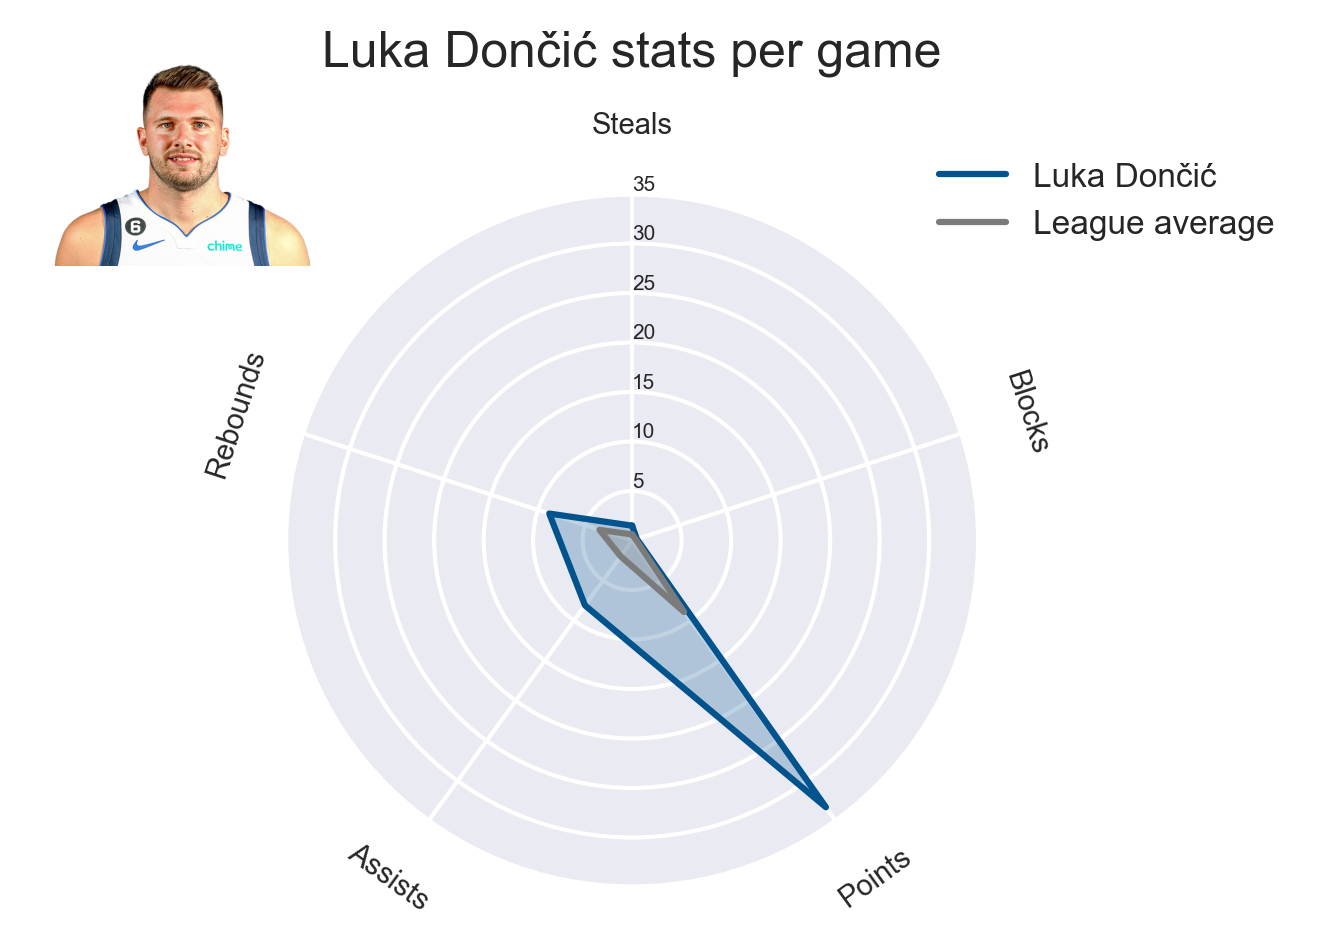

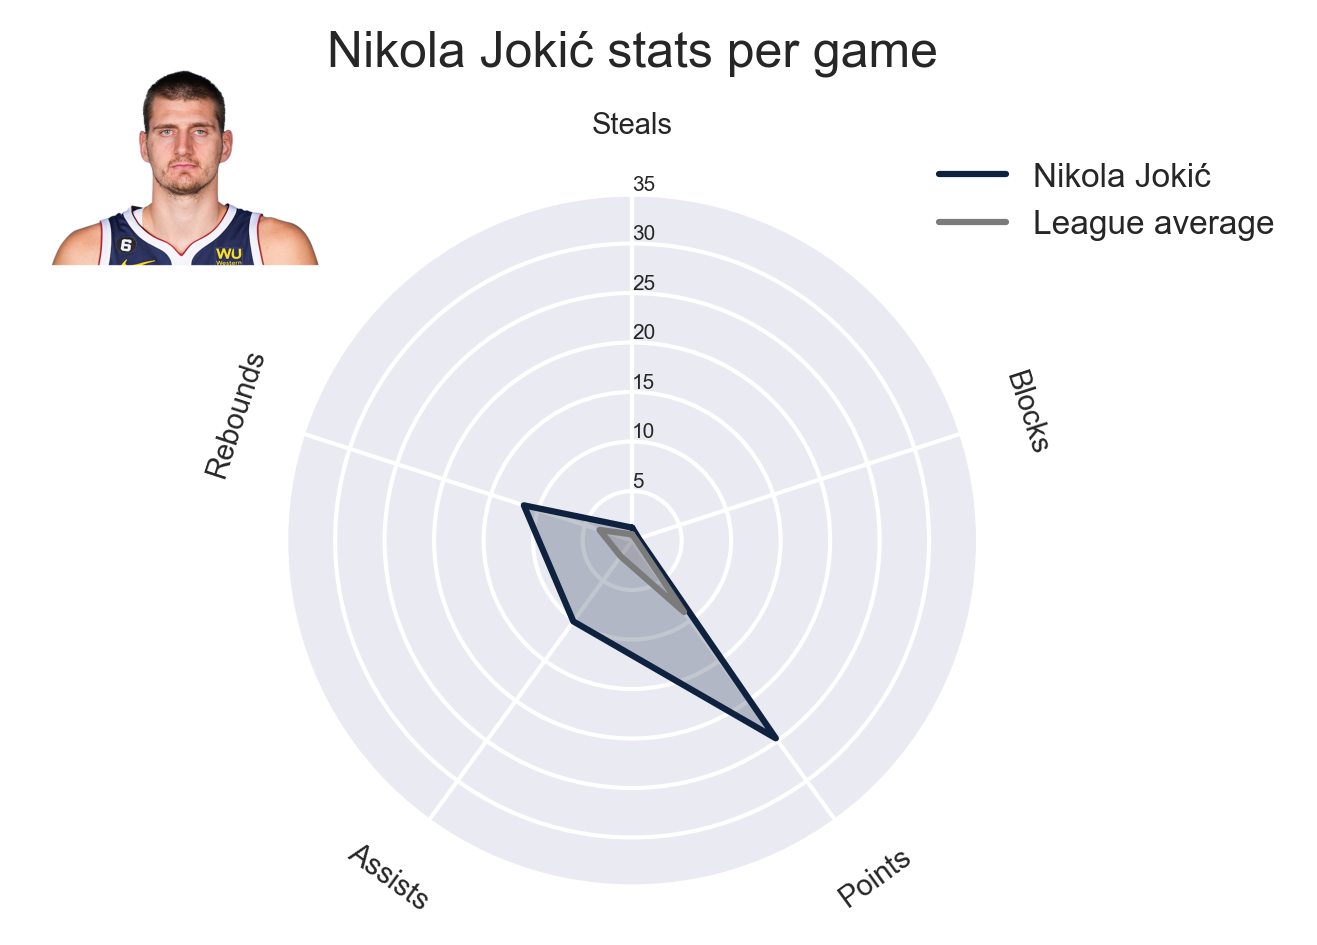

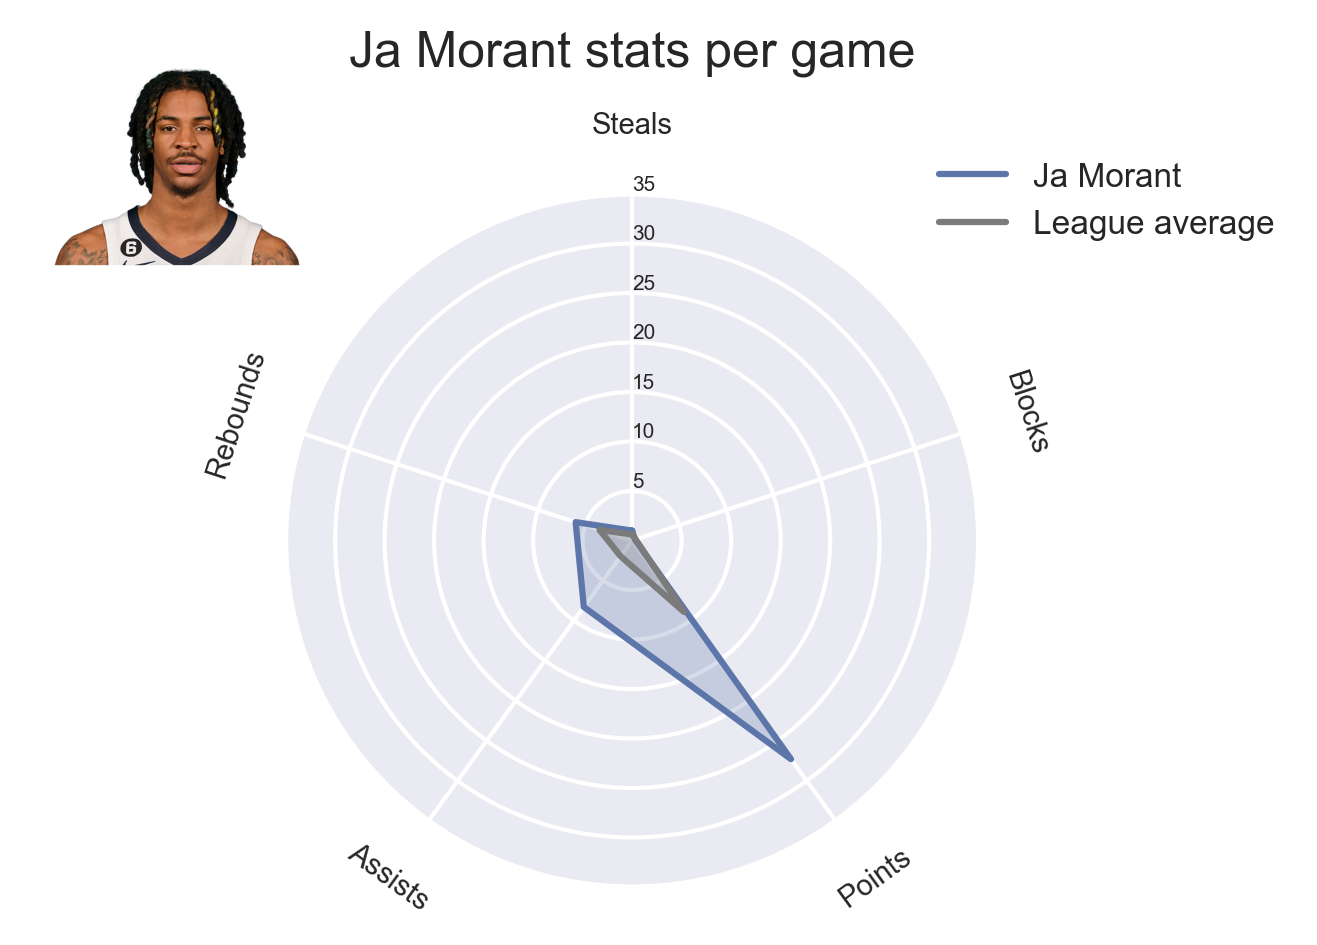

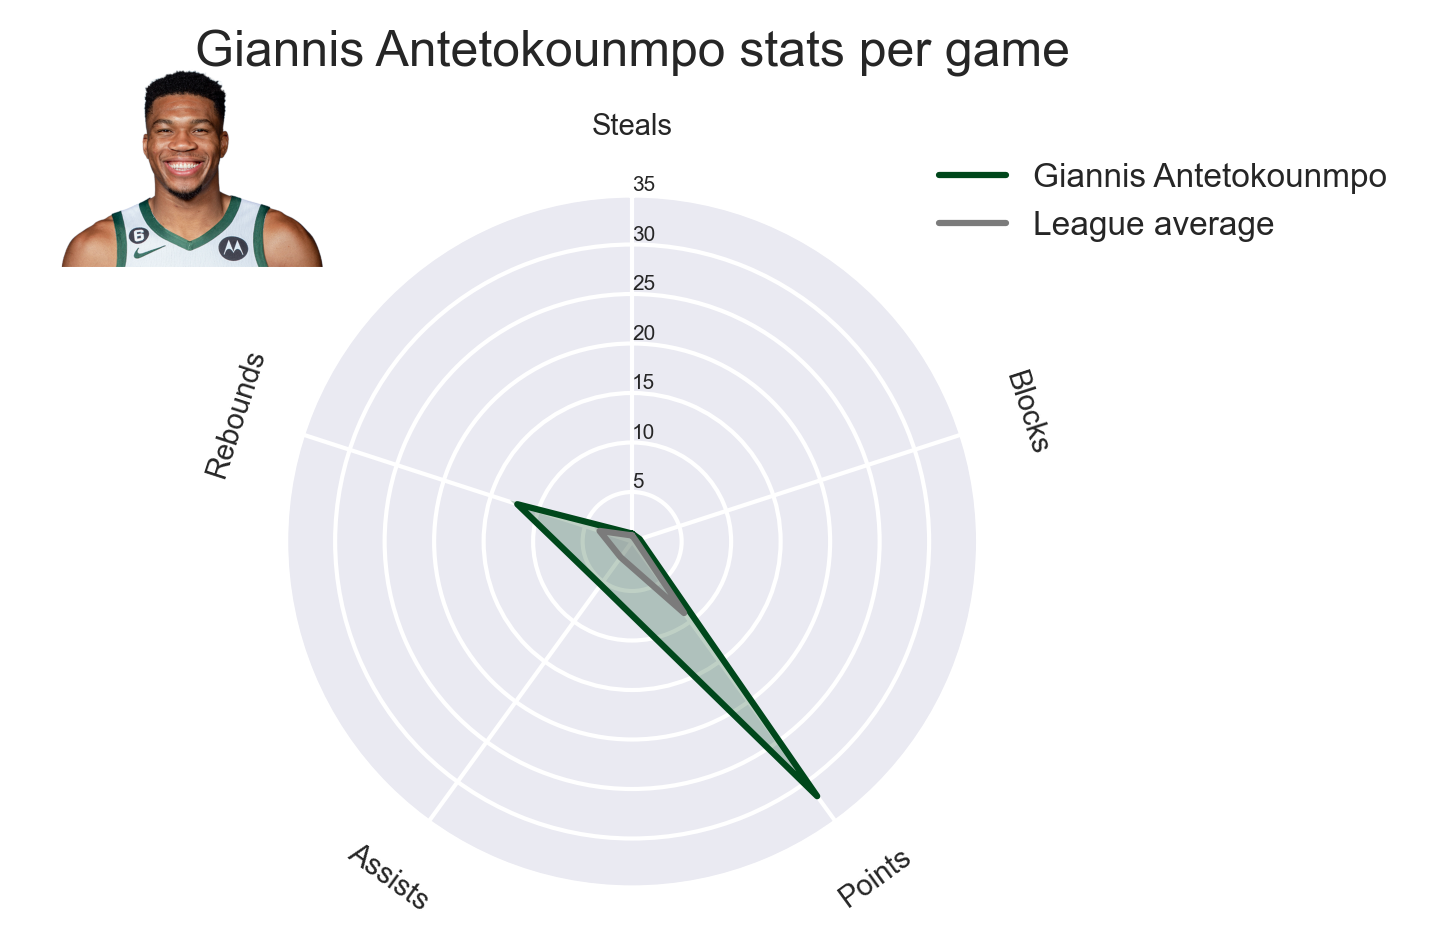

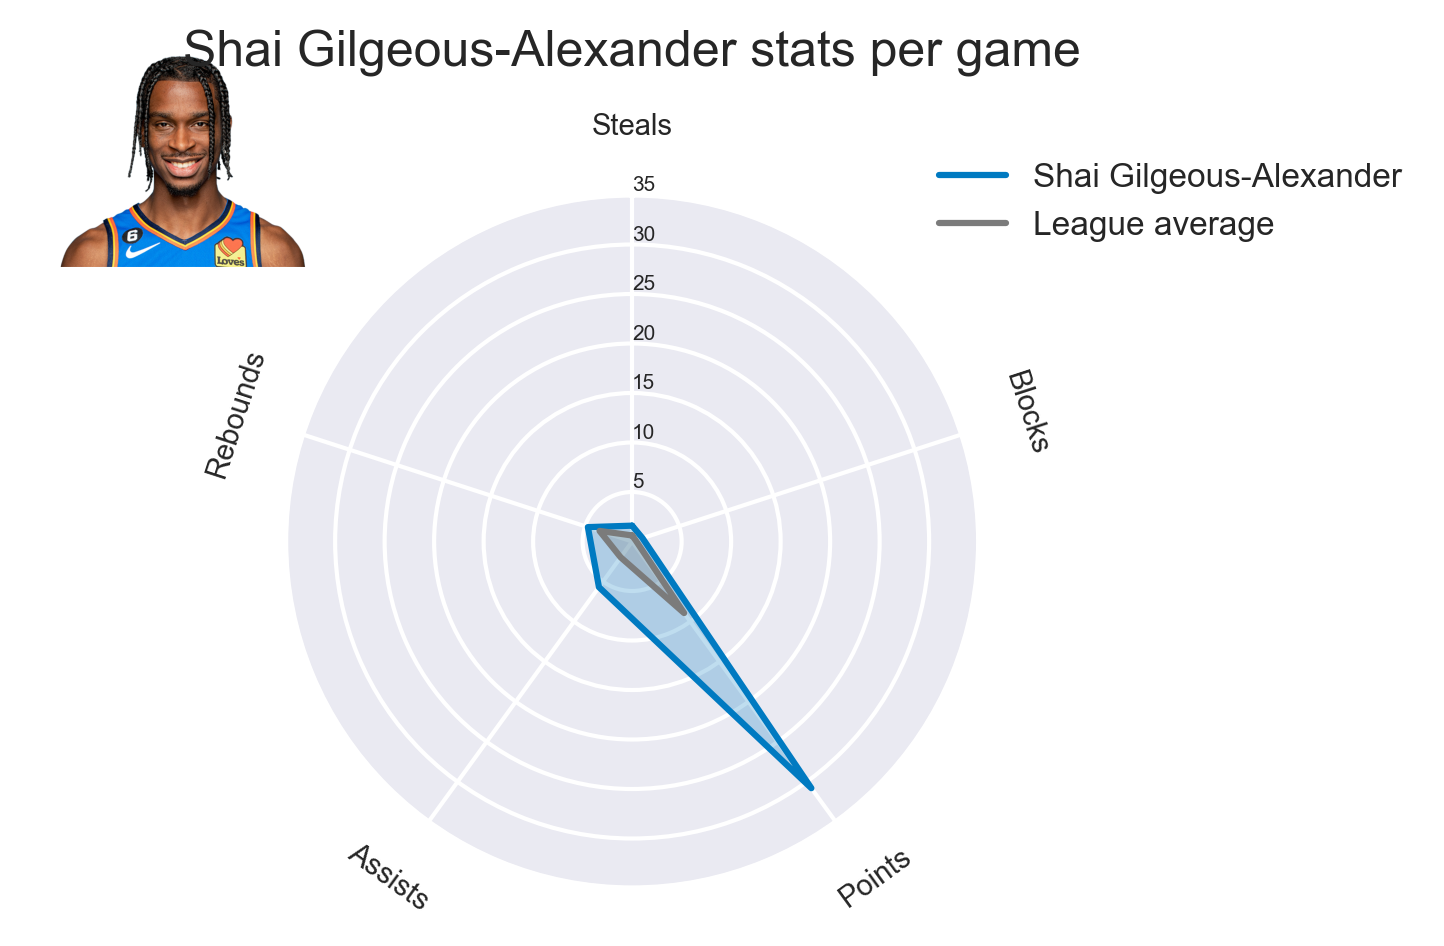

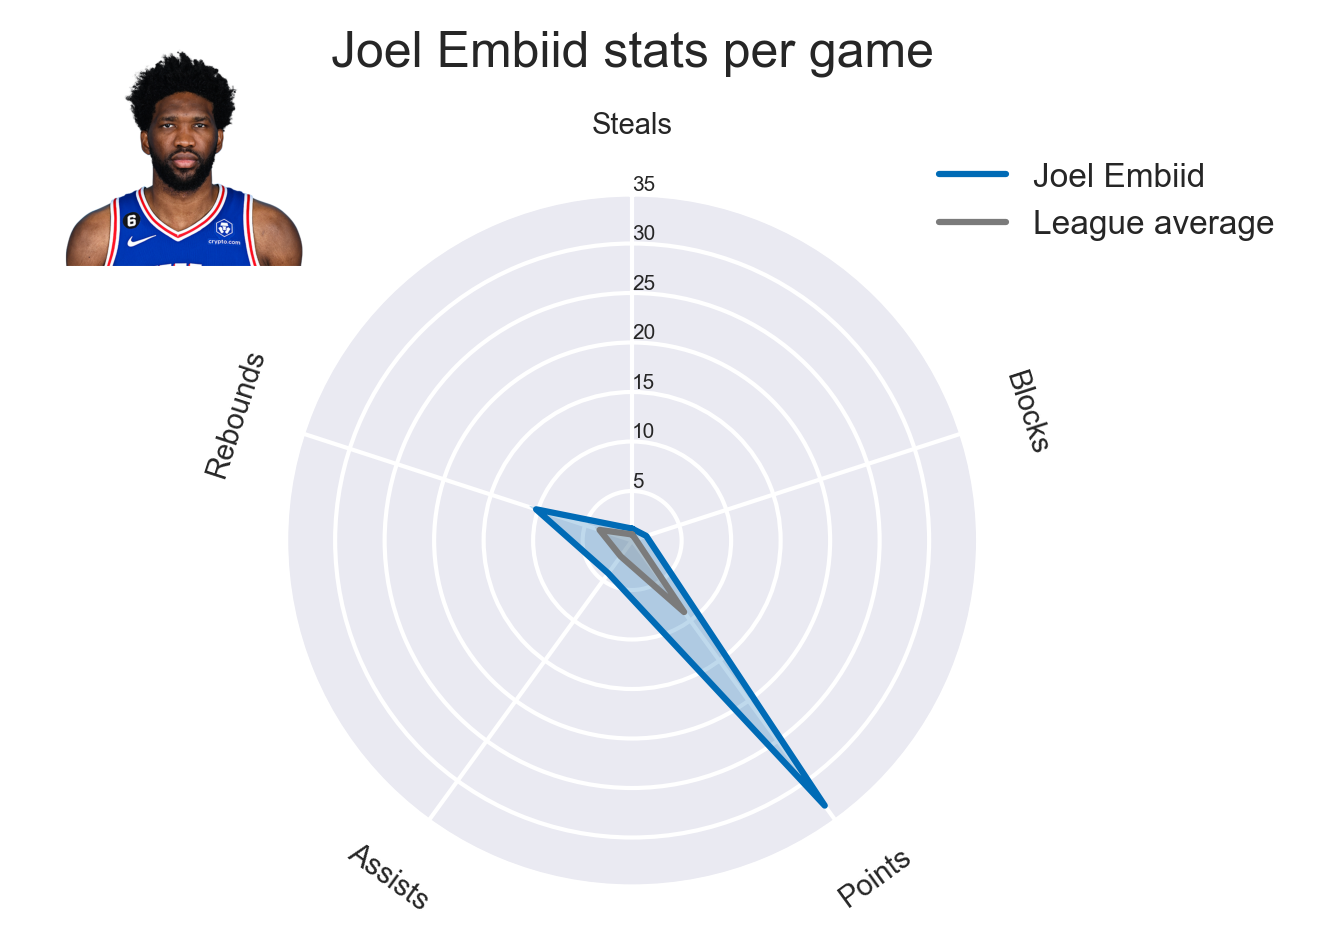

In [43]:
# Get player names
players = best_players["player"].values.tolist()

# Show one plot per player
for player in players:
    # Get player DataFrame
    player_df = best_players.loc[best_players["player"]==player]
    # Get player image
    name = player.split(" ")[0]
    img = plt.imread(f"{player_photos_dir}/{name}.png")
    radar_plot(player_df, nba, best_players, (1, 1, 1), 300, stats, stats_labels, "player", "color", img)

In the radar plots above, we can clearly appreciate that all of these players, as they lead their corresponding teams and are some of the best players in the league, have at least 25 points per game (worst case being Jokić). For instance, Dončić and Embiid have more than 33 points per game!

In the assists section, we can clearly see that Jokić leads this section with more than 10 assists per game. This is especially interesting when we consider that Jokić is a center, and this section is usually led by point guards such as Dončić or Morant.

The rebounds section is led by Antetokounmpo with 12.2 rebounds per game, which is again interesting considering he plays as a small forward, followed by Jokić and Embiid who are centers and therefore should typically have greater numbers in this category.

Regarding the defensive section (steals and blocks), in the former, they are all relatively close to each other, with Shai Gilgeous-Alexander and Dončić having the greatest numbers. In blocks per game, Embiid and Shai Gilgeous-Alexander lead, which is again interesting considering the latter usually plays as a point guard or shooting guard.

---

In summary, once we have analyzed not only the overall performance of the teams, but the performance of some of the players in the league and comparing the best of them, we may conclude that:

#### **1. NBA Eastern Conference** 

Boston Celtics and Milwaukee Bucks seem to be the strongest teams in the Eastern conference, followed by Philadelphia 76ers, which I will give some chances to reach the NBA finals. However, if I would need to give a prediction, I would go with Milwaukee Bucks. The reason behind this is because even though Celtics and Bucks are pretty similar in defense and in attacking style, winning Boston more convincingly on average and having Bucks better rebounding, I would say that because Bucks have a differential player such as Antetokounmpo, that may be key when facing each other. Celtics have Tatum, who is having a pretty good season, but he has not reached Antetokounmpo's level yet. Therefore, because both teams are very similar, having a key player such as Antetokounmpo may tip the scales for Bucks.

#### **2. NBA Western Conference**

In the Western conference, there are two teams which seem to be better than the rest: Denver Nuggets and Memphis Grizzlies. As an overall team, the latter seems to be better (best defensive team in the league, best rebounding in the Western conference), but although they have Ja Morant, who is one of the best players in the league, Denver Nuggets have probably the most differential player right now, which is Nikola Jokić. However, to win a championship, a team does not only need a single player, and Memphis seems to be a better overall team.

## **Final predictions**

### **NBA conference finals**

**Therefore, my predictions for the NBA conference finals are:**

**<u>Western Conference</u>: Denver Nuggets vs Memphis Grizzlies**

<div>
  <img src="https://a.espncdn.com/combiner/i?img=/i/teamlogos/nba/500/den.png" alt="Denver" style="width: 200px; height: auto; margin-left: 0px;">
  <img src="https://a.espncdn.com/combiner/i?img=/i/teamlogos/nba/500/mem.png" alt="Memphis" style="width: 200px; height: auto; margin-left: 0px;">
</div>

**<u>Eastern Conference</u>**: **Boston Celtics vs Milwaukee Bucks**

<div>
  <img src="https://a.espncdn.com/combiner/i?img=/i/teamlogos/nba/500/bos.png" alt="Boston" style="width: 200px; height: auto; margin-left: 0px;">
  <img src="https://a.espncdn.com/i/teamlogos/nba/500/mil.png" alt="Bucks" style="width: 200px; height: auto; margin-left: 0px;">
</div>

### **NBA final**

And the NBA finals will be:

**Memphis Grizzlies vs Milwaukee Bucks**

<div>
  <img src="https://a.espncdn.com/combiner/i?img=/i/teamlogos/nba/500/mem.png" alt="Memphis" style="width: 200px; height: auto; margin-left: 0px;">
  <img src="https://a.espncdn.com/i/teamlogos/nba/500/mil.png" alt="Bucks" style="width: 200px; height: auto; margin-left: 0px;">
</div>

### **NBA champion**

<p style="display: flex; align-items: center;">
    <img src="https://a.espncdn.com/i/teamlogos/nba/500/mil.png" alt="Bucks" style="width: 200px; height: auto; margin-left: 0px;">
</p>

And my prediction for the NBA winner in the 2022-23 season is **Milwaukee Bucks**.

Due to the fact that the Eastern conference seems to have better teams and having a differential player such as Antetokounmpo, who has already been the MVP twice. Moreover, Bucks won the NBA championship two years ago, and therefore have experience in these situations, whereas Memphis Grizzlies do not.

### **MVP**

<p style="display: flex; align-items: center;">
    <img src="https://cdn.nba.com/headshots/nba/latest/1040x760/203999.png" alt="Jokic" style="width: 200px; height: auto; margin-left: 0px;">
</p>

The MVP winner will be **Nikola Jokić**

He is clearly the player who most contributes to his team's success, and his team is currently the best team in the Western conference, as well being the most complete player among the MVP contenders (not the best in terms of points but is the best in assists per game, second-best in steals and rebounds, and third-best in blocks per game). Therefore, I would go for the Serbian player.
